# 0. Imports, Globals and Helpers

## 0.1 Import Libraries

In [1]:
# Imports

# SEC 1.
import numpy as np 
import pandas as pd 
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt 
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
import copy

# SEC 2
from sklearn import linear_model
from scipy.stats import pearsonr, iqr
from sklearn.decomposition import PCA

# SEC 3
from scipy.optimize import minimize

# SEC 4
from tabulate import tabulate
from statsmodels.robust.scale import mad as mad_c
import time 
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from lmfit.models import GaussianModel

# SEC 5
import seaborn as sns
import networkx as nx
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


%matplotlib inline

## 0.2 Global Variables 

In [2]:
# Global Helper Variables:
data_folder = 'Data/' 

In [3]:
# Used CMAP
CMAP = 'jet'
CMAP_OBJ = plt.cm.jet

In [4]:
# Save all images in PDF.
file_fmt = '.pdf'

In [5]:
# Lines formatting.
fmt_lines = {
    'linewidth' : 2,
}

# Labels formatting.
fmt_label = {
    'fontsize' : 12,
    'fontweight': 'normal',
}

# Titles formatting.
fmt_title = {
    'fontsize' : 14,
    'fontweight': 'bold',
}

# Parameters formatting.
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [6]:
# Unicodes for special characters.
uni = {       
        'i'        : ('\u2071',   '\u1d62'      ),
        'k'        : ('\u1d4f',   '\u2096'      ),
        'm'        : ('\u1d50',   '\u2098'      ),
        'o'        : ('\u1d52',   '\u2092'      ),
        's'        : ('\u02e2',   '\u209b'      ),
        't'        : ('\u1d57',   '\u209c'      ),
}

# Greek characters. 
sub =  {
    ':alpha' : '\u03B1',
    ':beta' : '\u03B2'
}

## 0.3 Helper Functions

In [7]:
def pretty_print(var, text = ''):
    '''
        Print tuples, list, and np.arrays in a tidy
        and easy to read fashion. 
        
        Arguments:
        - var : the variable to print
        - text: the name of the variable to display
                next to it.
        
        var and text MUST have the same size.
        
    '''
    
    print('----------------------------------')
    if isinstance(var, list) or isinstance(var, np.ndarray) and len(var) > 1:
        # If a list or array, print it in the form:
        # [
        #   text[i]: var[i]
        # ]
        print(text + ' : [')
        for el in var:
            print('\t ' + str(el) + ',')
        print(']')
        
    elif isinstance(var, tuple) and isinstance(text, tuple):
        # If var is a tuple, print it in the form:
        # text[i]: var[i]
        
        for i in range (len(var)):
            print('\033[1m' + text[i] + ' : \t \033[0m' + str(var[i]))       
    else:
        # else just print it.
        
        print(text + ' : \t' + str(var))
        
    print('----------------------------------')

In [8]:
def subplot_init(x, y, fig_size = (6,6), hspace = 0.55, wspace = 0.55):
    '''
        Initialise subplot with thight layout and specified figure size.
        
        Arguments:
        - x: number of rows in the subplot.
        - y: number of columns in the subplot.
    '''
    
    # Initialise figure and axes.
    fig, axes = plt.subplots(x, y)
    
    # Set figure size.
    fig.set_figheight(fig_size[0])
    fig.set_figwidth(fig_size[1])  
    
    # Set figure layout to tight.
    fig.tight_layout()
    
    # Set figure spacing.
    fig.subplots_adjust(hspace = hspace, wspace = wspace)
    
    return fig, axes

In [9]:
def bound_plot(ax, data, roll_mean, upper_bound, lower_bound, color1 = CMAP_OBJ(0), color2 = CMAP_OBJ(0.8),
               xlabel = '', ylabel = '', title = '', legend = None):
    '''
        function to plot z-bounds for price data.
        
        Arguments:
        - ax: the axis in which the plot must be included.
        - data: the price data.
        - roll_mean: the rolling mean series.
        - upper_bound: the upper bound for the Z-score.
        - lower_bound: the lower bound for the Z-score.
    '''
    
    # Plot data in color1.
    ax.plot(data, color = color1)
    
    # Plot rolling mean in color2.
    ax.plot(roll_mean, color = color2)
    
    # Plot bounds in faded color1.
    ax.plot(upper_bound, ':', color = color1, alpha = 0.25)
    ax.plot(lower_bound, ':', color = color1, alpha = 0.25)
    
    # Fill region between bounds in faded color1.
    ax.fill_between(roll_mean.index, upper_bound, lower_bound, color = color1, alpha = 0.25)
    
    # Format axes.
    nice_formatter(ax, xlabel, ylabel, title, legend_out = True, display_names = legend)

In [10]:
def pretty_plot(ax, var, var2 = None, label = '', color = CMAP_OBJ(0), alpha = 1):
    '''
        Function to plot one or two variable plots nicely in a specific axis.
        
        Arguments:
        - ax: axis in which the plot must be included.
        - var: if var2 is None, this will be considered as the data series to be plot.
        - var2: if var2 is not None, var and var2 will be plotted together.
    '''
    
    if var2 is None:
        # If single variable is given.
        
        if color == CMAP_OBJ(0):
            # Various cases to format the plot correctly.
            
            if isinstance(var, np.ndarray) or isinstance(var, list) :
                ax.plot(var, **fmt_lines, label = label, color = color, alpha = alpha)
            else:
                var.plot(ax = ax,  **fmt_lines, label = label, cmap = CMAP)
        else:
            if isinstance(var, np.ndarray):
                ax.plot(var, **fmt_lines, label = label, color = color, alpha = alpha)
            else:
                var.plot(ax = ax,  **fmt_lines, label = label, color = color, alpha = alpha)
    else:
        # Else plot both variables.
        
        ax.plot(var, var2, **fmt_lines, label = label, color = color, alpha = alpha)

In [11]:
def nice_formatter(ax, xlabel = '', ylabel = '', title = '', color = 'k',
                   legend_on = True, legend_out = False, grid_on = True,
                   display_names = []):
    '''
        Function to quickly add labels, title, legend and other important
        features to plots.
        
        Arguments:
        - ax: axis to format.
    '''
    
    # Set labels, title and ticks.
    ax.set_xlabel(xlabel, color = color, **fmt_label)
    ax.set_ylabel(ylabel, color = color, **fmt_label)
    ax.set_title(title, **fmt_title)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    # set grid on.
    if grid_on:
        ax.grid(b = True)
        
    # Set legend on if it is required.
    if legend_on:
        if legend_out: 
            if len(display_names) == 0:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else :
                ax.legend(display_names, bbox_to_anchor=(1.05, 1), loc='upper left')      
        else:
            if len(display_names) == 0:
                ax.legend()
            else :
                ax.legend(display_names)
    elif ax.get_legend(): 
        # remove legend if present.
        ax.get_legend().remove()

In [12]:
def jarque_bera_calc(var, idx):
    '''
        Function to compute the Jarque-Bera statistic of a series.
        
        Arguments:
        - var: data series.
        - idx: index of data in the series.
    '''
    x = [i for i in range (100, len(var.dropna()), 100)]
    jb = [stats.jarque_bera(var.dropna()[:i])[idx] for i in x]
    return jb, x


In [13]:
def get_opt_weights(C, returns):
    '''
        Function to find optimal weights from ccorrelation matrix.
        
        Arguments:
        - C: correlation matrix.
        - returns: returns data.
    '''
    one_matrix = np.ones((returns.shape[1], 1))
    l = 1 / ((one_matrix.T @ np.linalg.inv(C).T) @ one_matrix)
    opt_weights = l * (np.linalg.inv(C) @ one_matrix)
    opt_weights = opt_weights.reshape(-1, )
    
    return opt_weights

In [14]:
def savefig(fig, path):
    '''
        Function to save figures.
    '''
    fig.savefig(path, bbox_inches='tight')

In [15]:
def hist_plot(ax, data, bins = 100, color = CMAP_OBJ(0), label = ''):
    '''
        Function to plot histogram with single gaussian fit.
        
        Arguments:
        - ax: axis in which the plot must be included.
        - data: data to compute histogram.
    '''
    
    # Two cases to plot histogram based on the type of input data.
    if isinstance(data, np.ndarray) or isinstance(data, list):
        weights = np.ones_like(data)/float(len(data))
        (mu, std) = norm.fit(data)
        ax.hist(data, bins = bins, color = color, weights = weights, label = label)
    else:
        data = data.dropna()
        weights = np.ones_like(data)/float(len(data))
        (mu, std) = norm.fit(data)
        data.hist(ax = ax, bins = bins, color = color, weights = weights)
   
    # Get pdf parameters.
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    p = p / sum(p) * (100 / bins)
    
    # Plot the PDF.
    ax.plot(x, p, linewidth = 2, color = CMAP_OBJ(0.9))
    
    # Set ticks to percentages.
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

In [16]:
def gauss(x, mu, std, peak):
    '''
        Function that models a Gaussian curve.
    '''
    return peak * exp(-(x - mu) ** 2 / 2 / std ** 2)

def bimodal(x, mu1, std1, peak1, mu2, std2, peak2):
    '''
        Function that models a bi-Gaussian curve.
    '''
    return gauss(x, mu1, std1, peak1) + gauss(x, mu2, std2, peak2)

def trimodal(x, mu1, std1, peak1, mu2, std2, peak2, mu3, std3, peak3):
    '''
        Function that models a tri-Gaussian curve.
    '''
    return gauss(x, mu1, std1, peak1) + gauss(x, mu2, std2, peak2) + gauss(x, mu3, std3, peak3)

def hist_plot_multimodal(ax, data, expected, bins = 100, 
                         color1 = CMAP_OBJ(0), color2 = CMAP_OBJ(0.1), label = ''):
    '''
        Function that plots a histogram and models histogram data to fit a multigaussian distribution.
        
        Arguments:
        - ax: axis in which the plot must be included.
        - data: data to compute the histogram.
        - expected: expected means and standard deviations for Gaussians.
    '''
    
    # Define weights of 1.
    weights = np.ones_like(data)/float(len(data))
    
    # Plot histogram.
    y, bin_edges, _ = ax.hist(data, bins = bins, color = color1, weights = weights, label = label, alpha = 0.7)
    
    x = (bin_edges[:-1] + bin_edges[1:]) /  2.0 

    # build a model as a sum of 3 Gaussians.
    model = (GaussianModel(prefix='g1_') + GaussianModel(prefix='g2_') + 
             GaussianModel(prefix='g3_'))


    # Define parameters with initial values.
    params = model.make_params(
                g1_amplitude = expected[0], g1_center = expected[1], g1_sigma = expected[2],
                g2_amplitude = expected[3], g2_center = expected[4], g2_sigma = expected[5],
                g3_amplitude = expected[6], g3_center = expected[7], g3_sigma = expected[8],
             )
    
    # Perform the actual fit.
    result = model.fit(y, params, x = x)

    # Evaluate the model components ('g1_', 'g2_', and 'g3_')
    comps = result.eval_components(result.params, x = x)
    p = comps['g1_'] + comps['g2_'] + comps['g3_']
    p = p / sum(p)
    
    # Plot the final curve.
    ax.plot(x, p, linewidth = 2, color = color2)
    
    # Set ticks to percentages.
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


In [17]:
def portfolio_stats(portfolio):
    '''
       Function to retrieve portfolio statistics. 
    '''
    
    # Compute and return cumulative sum, mean and variance.
    cumsum = portfolio.cumsum()
    mean = portfolio.mean()
    var = portfolio.std() ** 2
    return [str(round(mean, 10)), str(round(cumsum[-1], 10)), str(round(var, 10))]

In [18]:
def graph_plotter(links, mean_corrs = None, cmap = plt.cm.Blues, node_color = 'powderblue',
                  with_labels = True, font_size = 14, width = 3, ax = None,
                  mean = 0.4, std = 0.15, fact = 3000):
    '''
        Function to format and plot graphs.
        
        Arguments:
        - links: pairs of connected elements to be included in the graph.
    '''
    
    # If ax is none plot to current axis.
    if ax is None:
        ax = plt.gca()
        
    # Build the graph with networkx from the links.
    G = nx.from_pandas_edgelist(links, 'var1', 'var2')

    # Get weights for connections.
    edges = G.edges
    weights = []
    for var1, var2 in edges:
        indexes_var1 = links.index[links['var1'] == var1].tolist()
        indexes_var2 = links.index[links['var2'] == var2].tolist()
        row = list(set(indexes_var1).intersection(indexes_var2))
        if len(row) == 0:
            weights.append(0)
        else:
            weights.append(links.loc[row[0]].value)
    weights = tuple(weights)

    
    if mean_corrs is None:
        # if no weighting of the nodes is required all weights have 2000 size.
        node_size = 2000
    else:
        # Compute dynamic weights for nodes.
        nodes = nx.nodes(G)
        node_size = np.array([])
        for n in nodes:
            node_size = np.append(node_size, mean_corrs.loc[n].values[0])
    
        # Standardise sizes to mean and std, then scale by fact.
        node_size = ((node_size - mean)/ std) * fact
    
    # Plot the network.
    nx.draw(G, with_labels = with_labels, edge_cmap = cmap, 
            node_color = node_color, node_size = node_size, edge_list = G.edges,
            edge_color = weights, width = width, font_size = font_size, ax = ax)
    
    

# 1. Regression Methods

In this section, regression methods are used to analyse the performance of some of the S&P 500stock market listed companies.

## 1.1 Processing stock price data in Python

### 1.1.1 Logarithmic prices

In [19]:
# Define path to save images.
section = 'img/sec1/1.1/'

In [20]:
# Import and format price data.
px = pd.read_csv(data_folder + "priceData.csv", header = 0, index_col = 0)
px = px.dropna()

In [21]:
# Log-prices.
logpx = np.log(px)

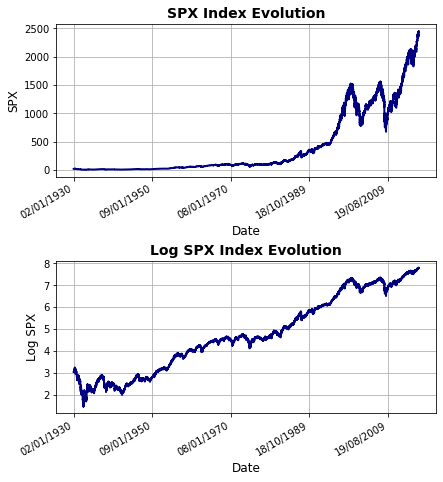

In [22]:
# Initialise subplot.
fig, axes = subplot_init(2,1)

# Plot prices and log-prices.
pretty_plot(axes[0], px)
pretty_plot(axes[1], logpx)

# Format axes.
nice_formatter(axes[0], 'Date', 'SPX', 'SPX Index Evolution', legend_on = False)
nice_formatter(axes[1], 'Date', 'Log SPX', 'Log SPX Index Evolution', legend_on = False)

# Save figure.
savefig(fig, section + 'index_evolution' + file_fmt)

### 1.1.2 Stationarity analysis using rolling statistics

A stochastic signal is stationary if, when shifted in time, its unconditional joint probability distribution does not
change and consequently its first moment is time-invariant.

While the sliding mean performs a smoothing operation on the signal, the standard deviation gives information on the price volatility. 
The plots in the figures below imply non-stationarity as the moving average follows an upwards trend with respect to time. Therefore both the price and the log-price time-series do not have time-invariant statistics, i.e. they are non-stationary stochastic processes.

In [23]:
# Define a window size.
w = 252

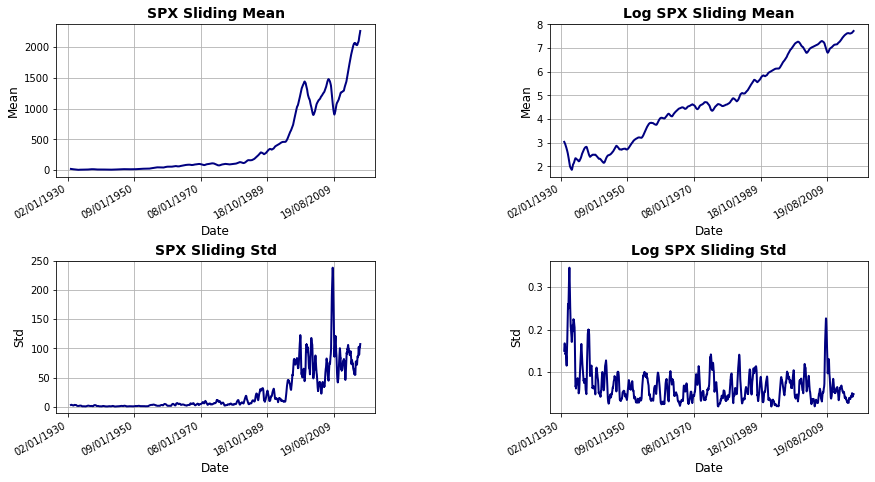

In [24]:
# Initialise subplot.
fig, axes = subplot_init(2,2, fig_size = (6, 12))

# Plot sliding window analysis of the prices.
pretty_plot(axes[0][0], px.rolling(w).mean())
pretty_plot(axes[1][0], px.rolling(w).std())

# Format plots.
nice_formatter(axes[0][0], 'Date', 'Mean', 'SPX Sliding Mean', legend_on = False)
nice_formatter(axes[1][0], 'Date', 'Std', 'SPX Sliding Std', legend_on = False)


# Plot sliding window analysis of log-prices.
pretty_plot(axes[0][1], logpx.rolling(w).mean())
pretty_plot(axes[1][1], logpx.rolling(w).std())

# Format axes.
nice_formatter(axes[0][1], 'Date', 'Mean', 'Log SPX Sliding Mean', legend_on = False)
nice_formatter(axes[1][1], 'Date', 'Std', 'Log SPX Sliding Std', legend_on = False)


# Save figure.
savefig(fig, section + 'both_sliding_mean' + file_fmt)

### 1.1.3 Compute simple and log return

The Simple Return is defined as:

\begin{equation}
    R_t = \frac{p_t}{p_{t-1}} -1 
\end{equation}

where $p_t$ is the price of a certain asset at time instant $t$ and $R_t$ is the simple return at the same time instant $t$.
Similarly, the logarithmic return is defined as:

\begin{equation}
    r_t = \log(p_t) - \log(p_{t-1}) 
\end{equation}

where $p_t$ is the price of a certain asset at time instant $t$ and $r_t$ is the log-return at the same time instant $t$.


In [25]:
# compute simple returns and log-returns.
simple_ret = px.pct_change() 
log_ret = logpx.diff()

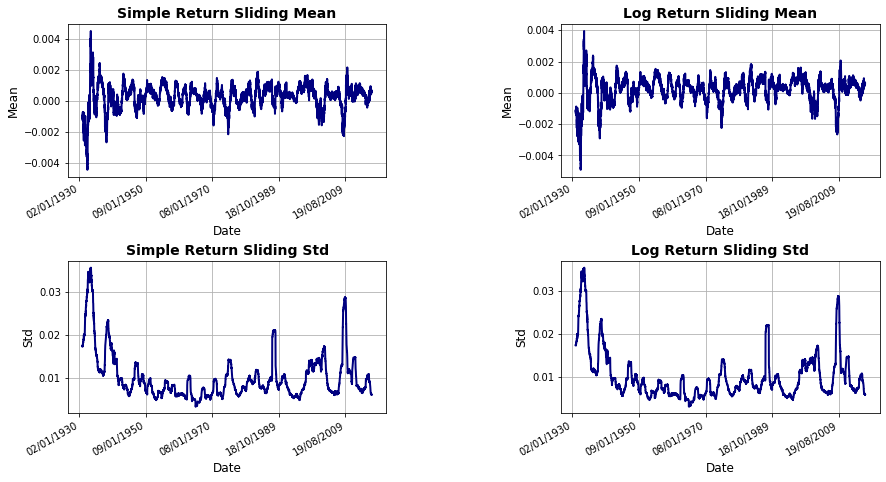

In [26]:
# Initialise subplot.
fig, axes = subplot_init(2,2, fig_size = (6, 12))

# Plot sliding window analysis of the simple returns.
pretty_plot(axes[0][0], simple_ret.rolling(w).mean())
pretty_plot(axes[1][0], simple_ret.rolling(w).std())

# Format axes.
nice_formatter(axes[0][0], 'Date', 'Mean', 'Simple Return Sliding Mean', legend_on = False)
nice_formatter(axes[1][0], 'Date', 'Std', 'Simple Return Sliding Std', legend_on = False)

# Plot sliding window analysis of log-returns.
pretty_plot(axes[0][1], log_ret.rolling(w).mean())
pretty_plot(axes[1][1], log_ret.rolling(w).std())

# Format axes.
nice_formatter(axes[0][1], 'Date', 'Mean', 'Log Return Sliding Mean', legend_on = False)
nice_formatter(axes[1][1], 'Date', 'Std', 'Log Return Sliding Std', legend_on = False)

# Save figure.
savefig(fig, section + 'both_return_sliding_mean' + file_fmt)


### 1.1.4 Advantages of log-returns and JB test

Considering the logarithmic return has several advantages over using the simple return.
First, the logarithmic function is monotonic, which means that the relative order is preserved, i.e. for all $a$ and $b$ such that $a > b$ then $\log(a) > \log(b)$.
Furthermore, prices are log-normally distributed over fairly short time periods, therefore the return at time $t$ ($r_t$) is normally distributed. Gaussianity is a fundamental advantage as several signal processing and statistical techniques require it. Finally logarithms as a mathematical operator are more convenient when performing advanced calculus and provide better numerical stability.
In this experiment, we can observe the gaussian-like behaviour of returns by plotting histograms showing both the simple return and log-return distribution.

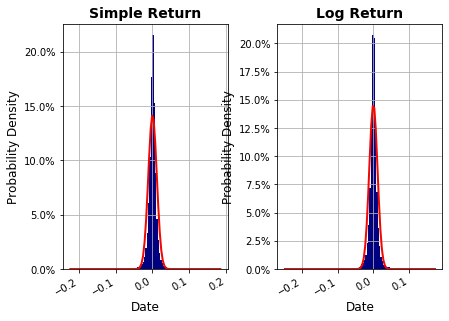

In [27]:
# Initialise subplot.
fig, axes = subplot_init(1,2, fig_size = (4, 6))

# Plot the PDF histogram of simple and log-returns.
hist_plot(axes[0], simple_ret)
hist_plot(axes[1], log_ret)

# Format axes.
nice_formatter(axes[0], "Date", "Probability Density", 'Simple Return', legend_on = False)
nice_formatter(axes[1], "Date", "Probability Density", 'Log Return', legend_on = False)

# Save figure.
savefig(fig, section + 'simple_log_return_hist' + file_fmt)

In [28]:
# Compute simple and logarithmic Jarque-Bera. 
log_JB, _ = jarque_bera_calc(log_ret, 0)
simple_JB, x = jarque_bera_calc(simple_ret, 0)

Gaussianity of data cannot only be appreciated through visual inspection, but also estimated using the Jarque-Bera goodness-of-fit test. 
This statistic quantifies how much the skewness and kurtosis of the sample data, i.e. symmetries and shape of the curve, match the ones of a normal distribution with zero skewness and kurtosis equal to three. 
the figure below shows the JB curve with respect to the number of data points considered, clearly showing 
that the difference among the two curves increases as the number of data points increases. Log-returns are proven to deviate more slowly from normality, hence making them more suitable for several statistical

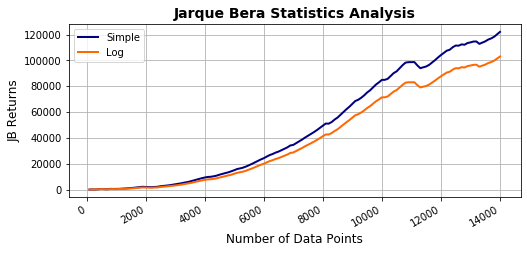

In [29]:
# Initialise subplot.
fig, ax = subplot_init(1,1, fig_size = (3, 7))

# Plot the JB statistic curve.
pretty_plot(ax, x[:140], var2 = np.array(simple_JB[:140]), label = "Simple")
pretty_plot(ax, x[:140], var2 = np.array(log_JB[:140]), label = "Log", color = CMAP_OBJ(0.8))

# Format axes.
nice_formatter(ax, 'Number of Data Points', 'JB Returns',
               'Jarque Bera Statistics Analysis')

# Save figures.
savefig(fig, section + 'jarque_bera_stats' + file_fmt)

In [30]:
# Print simple and log return JB statistics and p-value.
pretty_print(stats.jarque_bera(log_ret.dropna()), ('Log return JB', 'p-value\t\t'))
pretty_print(stats.jarque_bera(simple_ret.dropna()), ('Simple return JB', 'p-value\t\t'))

----------------------------------
Log return JB : 	 309277.64126696053
p-value		 : 	 0.0
----------------------------------
----------------------------------
Simple return JB : 	 257540.06493683602
p-value		 : 	 0.0
----------------------------------


### 1.1.5 Stock purchase example

*You purchase a stock for £1. The next day its value goes up to £2 and the following day back to £1.
What are the simple and logarithmic returns over this period and what can you conclude about logarithmic
returns on the basis of this example?*

The example above shows why log-returns are a better metric at describing the changes in value of an asset over time. Overall the value of the stock has not changed, given that eventually falls back to £1. However looking only at the simple returns ($[1, -0.5]$), their sum does not add up to zero. On the contrary, the log-returns ($[0.69, -0.69]$) cancel out, giving a better intuition that the asset did not gain or lose any value.

In [31]:
# Print returns and log-returns for the example given.
example = pd.Series([1,2,1])
pretty_print((example.pct_change()[1:].values, np.log(example).diff()[1:].values), ('Simple return', 'Log return\t'))

----------------------------------
Simple return : 	 [ 1.  -0.5]
Log return	 : 	 [ 0.69314718 -0.69314718]
----------------------------------


### 1.1.6 Advantages of simple returns

It should be mentioned that there are some properties of log-returns which make them less suitable than simple returns in certain situations. Firstly log-normality disappears on longer time spans, so it does not affect long-term analysis. Furthermore log-returns are not additive across assets while simple returns are, hence making the latter a more suitable option in portfolio formulation. 

## 1.2 ARMA vs. ARIMA Models for Financial Applications

The ARIMA (Auto Regressive Integrated Moving Average) model is a widely used time-series forecasting model. It is a more sophisticated version of the ARMA (Auto Regressive Moving Average) model. The functionality of these two models is summarised in by the two main components: 

**Auto Regressive**: The model attempts to predict future values based on past values in a stationary time series.

**Moving Average**: The models attempts to predict future values based on past forecasting errors.

### 1.2.1 Advantages of ARMA and ARIMA models

In [32]:
# Define path to save figures.
section = 'img/sec1/1.2/'

In [33]:
# Retrieve s&p 500 price data.
snp = pd.read_csv(data_folder + 'snp_500_2015_2019.csv', index_col=0)
snp_close = snp['Close'].to_frame().apply(np.log)

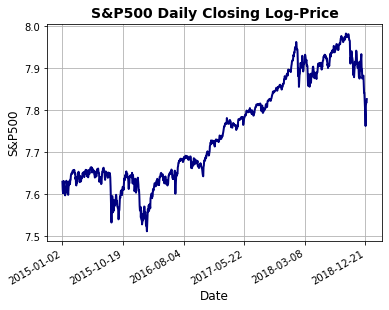

In [34]:
# Plot plot s&p close prices.
pretty_plot(plt.gca(), snp_close)

# Format axes.
nice_formatter(plt.gca(), 'Date', 'S&P500', 'S&P500 Daily Closing Log-Price', legend_on = False)

# Save figure.
savefig(plt.gcf(), section + 'closing_log_price' + file_fmt)

In [35]:
# Define window size.
w = 252 

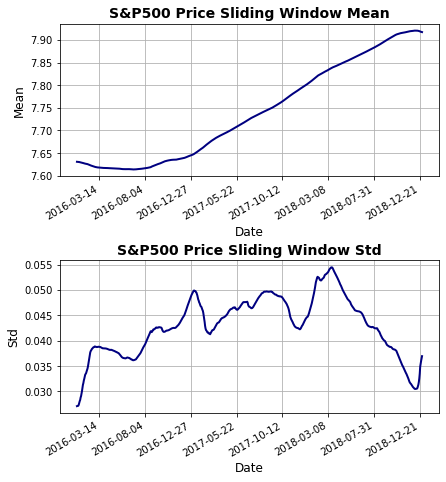

In [36]:
# Initialise subplot.
fig, axes = subplot_init(2, 1)

# Plot sliding window statistics on s&p close prices.
pretty_plot(axes[0], snp_close.rolling(w).mean())
pretty_plot(axes[1], snp_close.rolling(w).std())

# Format axes.
nice_formatter(axes[0], 'Date', 'Mean', 'S&P500 Price Sliding Window Mean', legend_on = False)
nice_formatter(axes[1], 'Date', 'Std', 'S&P500 Price Sliding Window Std', legend_on = False)

# Save figure.
savefig(fig, section + 'sliding_window_stats' + file_fmt)

### 1.2.2 ARMA (1, 0) modelling

In [37]:
# Define days range to zoom in.
days = range(150,250)

# Retrieve s&p data for ARMA model.
snp_arma = copy.deepcopy(snp_close)
snp_arma.columns = ['Actual']

In [38]:
# Find the residual fitting the model and calculate the prediction.
snp_arma['Residual'] = ARIMA(snp_arma['Actual'].values, order=(1, 0, 0)).fit().resid
snp_arma['Predicted'] = snp_arma['Actual'] - snp_arma['Residual']

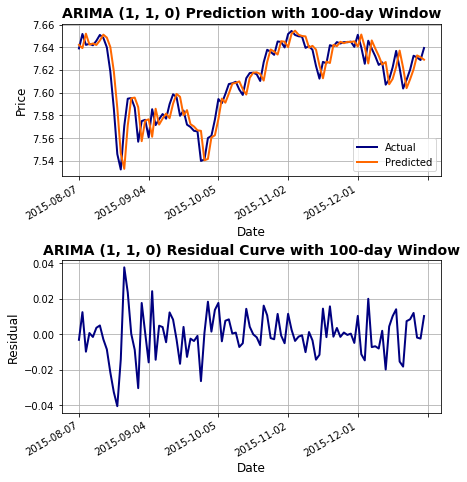

In [39]:
# Initialise subplot.
fig, axes = subplot_init(2, 1)

# Plot actual vs predicted prices in the zoomed window.
pretty_plot(axes[0], snp_arma['Actual'][days], label = "Actual", color = CMAP_OBJ(0))
pretty_plot(axes[0], snp_arma['Predicted'][days], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
nice_formatter(axes[0], 'Date', 'Price', 'ARIMA (1, 1, 0) Prediction with 100-day Window')

# Plot the residuals only.
pretty_plot(axes[1], snp_arma['Residual'][days])

# Format the second axis.
nice_formatter(axes[1], 'Date', 'Residual', 
               'ARIMA (1, 1, 0) Residual Curve with 100-day Window', legend_on = False)


# Save figure.
savefig(fig, section + 'ARMA_prediction_50' + file_fmt)


----------------------------------
Mean Absolute Residual : 	0.005974467968794472
----------------------------------


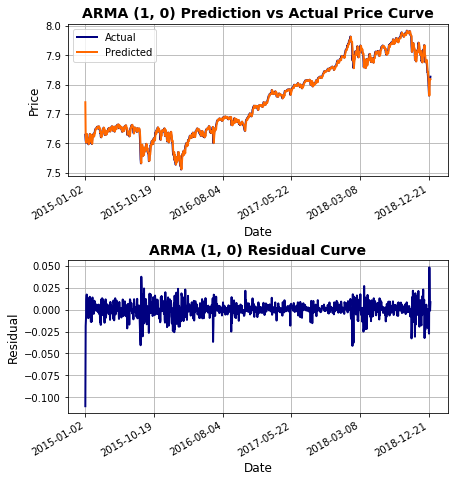

In [40]:
# Initialise subplot.
fig, axes = subplot_init(2, 1)

# Plot actual vs predicted prices for the whole series. 
pretty_plot(axes[0], snp_arma['Actual'], label = "Actual", color = CMAP_OBJ(0))
pretty_plot(axes[0], snp_arma['Predicted'], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
nice_formatter(axes[0], 'Date', 'Price', 'ARMA (1, 0) Prediction vs Actual Price Curve')

# Plot the residual only.
pretty_plot(axes[1], snp_arma['Residual'])

# Format the second axis.
nice_formatter(axes[1], 'Date', 'Residual', 'ARMA (1, 0) Residual Curve', legend_on = False)

# Save figure.
savefig(fig, section + 'ARMA_prediction' + file_fmt)

# Print Mean Absolute Residual.
pretty_print(np.mean(abs(snp_arma['Residual'])), 'Mean Absolute Residual')

In [41]:
# print the model parameters.
pretty_print(ARIMA(snp_arma['Actual'].values, order=(1,0,0)).fit().arparams, 'Model Parameters')

----------------------------------
Model Parameters : 	[0.99735931]
----------------------------------


### 1.2.3 ARIMA (1, 1, 0) modelling

In [42]:
# Define actual, predicted and residuals for ARIMA(1, 1, 0) model.
actual = snp_arma['Actual'][1:]
residual = ARIMA(snp_arma['Actual'].values, order=(1, 1, 0)).fit().resid
predicted = snp_arma['Actual'][1:] - residual

# Cast to pd.Series.
residual = pd.Series(data = residual, index = actual.index)
predicted = pd.Series(data = predicted, index = actual.index)

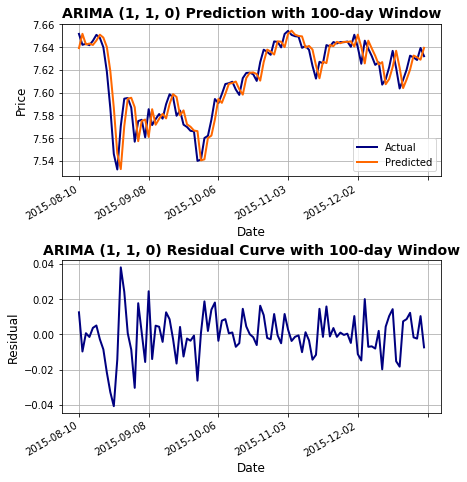

In [43]:
# Initialise subplot.
fig, axes = subplot_init(2, 1)

# Plot actual vs predicted prices for the 100 days zoomed window. 
pretty_plot(axes[0], actual[days], label = "Actual", color = CMAP_OBJ(0))
pretty_plot(axes[0], predicted[days], label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
nice_formatter(axes[0], 'Date', 'Price', 'ARIMA (1, 1, 0) Prediction with 100-day Window')

# Plot residuals.
pretty_plot(axes[1], residual[days])

# Format second axis.
nice_formatter(axes[1], 'Date', 'Residual', 'ARIMA (1, 1, 0) Residual Curve with 100-day Window',
               legend_on = False)

# Save figure.
savefig(fig, section + 'ARIMA_prediction_50' + file_fmt)

----------------------------------
Mean Absolute Residual : 	0.005847927277773153
----------------------------------


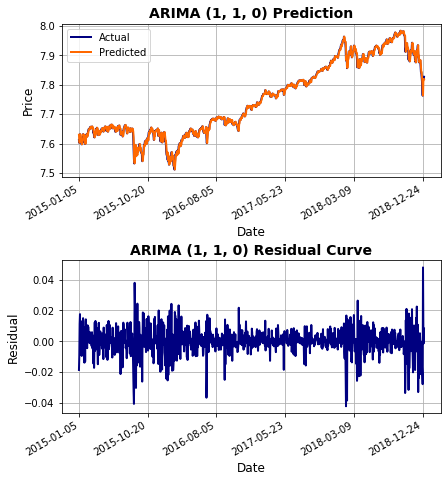

In [44]:
# Initialise subplot.
fig, axes = subplot_init(2, 1)

# Plot actual vs predicted prices for the whole series. 
pretty_plot(axes[0], actual, label = "Actual", color = CMAP_OBJ(0))
pretty_plot(axes[0], predicted, label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
nice_formatter(axes[0], 'Date', 'Price', 'ARIMA (1, 1, 0) Prediction')

# Plot residuals only.
pretty_plot(axes[1], residual)

# Format second axis.
nice_formatter(axes[1], 'Date', 'Residual', 'ARIMA (1, 1, 0) Residual Curve', legend_on = False)

# Save figure.
savefig(fig, section + 'ARIMA_prediction' + file_fmt)

# Print Mean Absolute Residual.
pretty_print(np.mean(abs(residual)), 'Mean Absolute Residual')

In [45]:
# Print model parameters.
pretty_print(ARIMA(snp_arma['Actual'].values, order=(1,1,0)).fit().arparams, 'Model Parameters')

----------------------------------
Model Parameters : 	[-0.00875135]
----------------------------------


### 1.2.4 ARIMA analysis with log-prices

In [46]:
# Define input data for the log-price analysis with ARIMA model.
snp_arma = copy.deepcopy(snp['Close'].to_frame())
snp_arma.columns = ['Actual']

In [47]:
# define residuals, actual and predicted prices by fitting the model
actual = snp_arma['Actual'][1:]
residual = ARIMA(snp_arma['Actual'].values, order=(1, 1, 0)).fit().resid
predicted = snp_arma['Actual'][1:] - residual

# Compute log-prices.
actual = np.log(actual)

# Cast to Series.
predicted = pd.Series(data = np.log(predicted), index = actual.index)
residual = pd.Series(data = actual - predicted, index = actual.index)

----------------------------------
Mean Absolute Residual : 	0.005848994236285218
----------------------------------


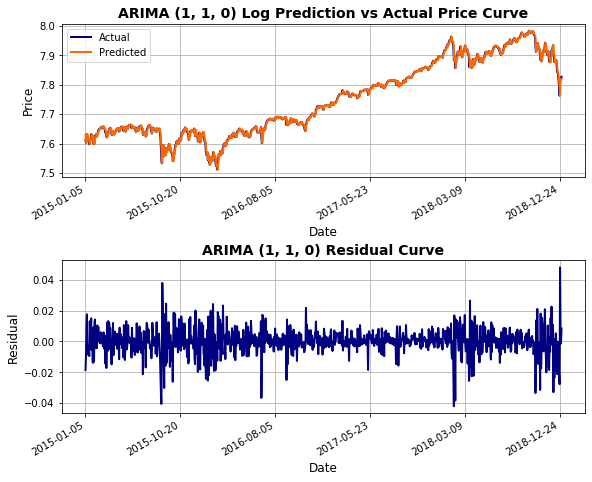

In [105]:
# Initialise subplot.
fig, axes = subplot_init(2, 1, fig_size = (6, 8))

# Plot actual vs predicted prices for the whole series. 
pretty_plot(axes[0], actual, label = "Actual", color = CMAP_OBJ(0))
pretty_plot(axes[0], predicted, label = "Predicted", color = CMAP_OBJ(0.8))

# Format first axis.
nice_formatter(axes[0], 'Date', 'Price', 'ARIMA (1, 1, 0) Log Prediction vs Actual Price Curve')

# Plot residuals only.
pretty_plot(axes[1], residual)

# Format second axis.
nice_formatter(axes[1], 'Date', 'Residual', 'ARIMA (1, 1, 0) Residual Curve', legend_on = False)

# Save figure.
savefig(fig, section + 'ARIMA_prediction_log' + file_fmt)

# Print Mean Absolute Residual.
pretty_print(np.mean(abs(residual)), 'Mean Absolute Residual')

In [49]:
# Print model parameters.
pretty_print(ARIMA(snp_arma['Actual'].values, order=(1,1,0)).fit().arparams, 'Model Parameters')

----------------------------------
Model Parameters : 	[-0.00674986]
----------------------------------


## 1.3 Vector Autoregressive (VAR) Models

### 1.3.1 Concise matrix form

In [50]:
# Define path for images.
section = 'img/sec1/1.3/'

Vector Autoregressive Models are multivariate extensions of AR models. VAR(p) processes are modelled by the following equation:
\begin{equation}
   \textbf y_t = \textbf{c} + \sum_{i = 1}^{p} \textbf A_i \textbf y_{t-i} + \textbf e_t  
\end{equation}
where $p$ is the model order, $\textbf y_i \in R^{k\times1} \; \forall i \in [t-1, t-p]$ , $\textbf A_i \in R^{k \times k} \; \forall i \in [1, p]$,  $\textbf c \in R^{k\times1}$ and $\textbf e_t \in R^{k\times1} \; \forall t$.
The equation above can be expanded in matrix form as:
\begin{equation}
    \begin{bmatrix}
    y_{1, t}\\
    y_{2, t} \\
    \vdots \\
    y_{k, t}
    \end{bmatrix} = 
    \begin{bmatrix}
    c_{1}\\
    c_{2} \\
    \vdots \\
    c_{k}
    \end{bmatrix} + 
    \sum_{i=1}^p
    \begin{bmatrix}
    a_{1, 1}^i & a_{1, 2}^i & \dots & a_{1, k}^i  \\
    a_{2, 1}^i & a_{2, 2}^i & \dots & a_{2, k}^i  \\
    \vdots & \vdots & \ddots & \vdots \\
    a_{k, 1}^i & a_{2k, 2}^i & \dots & a_{k, k}^i  \\
    \end{bmatrix}
    \begin{bmatrix}
    y_{1, t-i}\\
    y_{2, t-i} \\
    \vdots \\
    y_{k, t-i}
    \end{bmatrix} +
    \begin{bmatrix}
    e_{1, t}\\
    e_{2, t} \\
    \vdots \\
    e_{k, t}
    \end{bmatrix}\ ,
\end{equation}
which can be rewritten more concisely by making use of the matrices
\begin{equation}
    \textbf B = \begin{bmatrix}
    \textbf c & \textbf A_1 & \dots & \textbf A_p
    \end{bmatrix} 
\end{equation}
\begin{equation}
    \textbf Z = \begin{bmatrix}
    1 \\
    \textbf y_{t-1} \\
    \vdots \\
    \textbf y_{t-p}
    \end{bmatrix} 
\end{equation}
\begin{equation}
    \textbf Y = \textbf y_t
\end{equation}
\begin{equation}
    \textbf U = \textbf e_t
\end{equation}
The resulting equation for the VAR model is:
\begin{equation}
    \textbf{Y} = \textbf{BZ} + \textbf{U}
\end{equation}


### 1.3.2 VAR optimal coefficients


Minimising the cost function $J$ yields the optimal solution $\textbf B^*$. The least-squares method can be used to minimise the squared elements of the error term $\textbf U$. Therefore, the cost function $J$ can be defined as $J = \textbf U^T \textbf U = \textbf W$ where $\textbf W$ is the covariance matrix of errors and has dimensions $R^{T \times T}$.
Expanding the definition of $J$ the following matrix manipulations can be performed on the cost function:

\begin{equation} \label{eq:J}
    J = \textbf U^T \textbf U = (\textbf Y - \textbf{BZ})^T(\textbf Y - \textbf{BZ})
    = \textbf Y^T \textbf Y - \textbf Y^T \textbf{BZ} - \textbf B^T \textbf Z^T \textbf Y + \textbf B^T \textbf Z^T \textbf{BZ}  
\end{equation}

where both $\textbf{Y}$, $\textbf{B}$ and $\textbf{Z}$ are symmetric. This implies that their mutual products retain this property and that taking the transpose of any mutual product is equivalent to the product of the original matrices transposed. This means that $ \textbf Y^T \textbf{BZ} = \textbf B^T \textbf Z^T \textbf Y $ and  $\textbf B^T \textbf Z^T = \textbf{BZ}$, which can be used further to simplify the cost function further as follows:

\begin{equation} \label{}
    J =  \textbf Y^T \textbf Y - 2\textbf Y^T \textbf{BZ} + (\textbf{BZ})^2  
\end{equation}

To find the optimal solution $\textbf B^*$ the derivative of the cost function is set to zero, leading to 

\begin{equation}\label{}
    \frac{\partial J}{\partial B} =  - 2\textbf Y^T \textbf{Z} + 2(\textbf{BZ})\textbf{Z} = 0\ ,
\end{equation}

that is further simplified to the final value of $\textbf B^*$:

\begin{equation}\label{}
    2\textbf Y \textbf{Z}^T = 2(\textbf{BZ})\textbf{Z}^T 
\end{equation}

\begin{equation} \label{Bopt}
    \textbf B^* = \textbf Y^T \textbf{Z}(\textbf{ZZ}^T)^{-1}
\end{equation}


### 1.3.3 VAR eigenvalues

Consider the following VAR(1) process:
\begin{equation} \label{eq:var1}
    \textbf y_t = \textbf A \textbf y_{t-1} + \textbf e_t   
\end{equation}
Recursively substituting for earlier timesteps the equation for $\textbf y_t$ can be rewritten as:
\begin{equation} \label{eq:varsum}
    \textbf y_t = \textbf A_1^t \textbf y_{0} + \sum_{i=0}^{t-1} \textbf A_1^i \textbf e_{t-i}   
\end{equation}
This implies that the set of vectors $\textbf y_i$ for $i \in \{1, 2, ..., t\}$  and their joint distribution are uniquely dependent on $\textbf y_0$ and  $\textbf e_i$ for $i \in \{1, 2, ..., t\}$.
Therefore, taking into consideration an $n \times n$ matrix $\textbf A$ with eigenvalues  $ \lambda_i$ for $i \in \{1, 2, ..., m\} $, then it must exist a non-singular matrix $\textbf D$ such that $\textbf A = \boldsymbol{D \Lambda D^{-1}} $ , where $\textbf D$ and $\boldsymbol \Lambda \in R ^{n \times n}$. $\textbf A = \boldsymbol{D \Lambda D^{-1}} $ is mathematically defined as the singular value decomposition (SVD) of $\textbf A$ where $\boldsymbol \Lambda$ is a diagonal matrix of $\textbf A$ 's eigenvalues as follows: 
\begin{equation}
    \boldsymbol \Lambda^i = \begin{bmatrix}
    \lambda_1^i & 0 & \dots & 0 \\
    0 & \lambda_2^i & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & \lambda_n^i
    \end{bmatrix} 
\end{equation}
This definition implies that only if all the eigenvalues of matrix $\textbf A_1$ have modulus smaller than 1, then the summation does not diverge to $+\infty$.

### 1.3.4  Moving average VAR portfolio analysis

In [51]:
# Define window size.
w = 66

In [52]:
# Retrieve dataframes.
df = pd.read_csv(data_folder + 'snp_allstocks_2015_2019.csv', header = 0, index_col = 0)
info = pd.read_csv(data_folder + 'snp_info.csv', index_col = 0)

In [53]:
# Define subset of stocks.
tks = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tks]

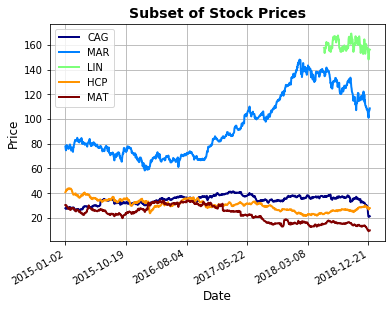

In [54]:
# Plot stock prices. 
pretty_plot(plt.gca(), stocks)

# Format axis.
nice_formatter(plt.gca(), 'Date', 'Price', 'Subset of Stock Prices')

# Save figure.
savefig(plt.gcf(), section + 'subset_stock_prices' + file_fmt)

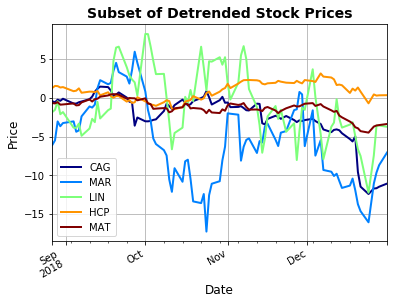

In [55]:
# Compute moving average.
move_avg = stocks.rolling(window = w).mean()

# Detrend moving average.
detrended = stocks.sub(move_avg).dropna()
detrended.index = pd.DatetimeIndex(detrended.index).to_period('D')

# Plot detrended stock prices.
pretty_plot(plt.gca(), detrended)

# Format axis.
nice_formatter(plt.gca(), 'Date', 'Price', 'Subset of Detrended Stock Prices')

# Save figure.
savefig(plt.gcf(), section + 'detrended_stock_prices' + file_fmt)


In [56]:
# define VAR modle on the detrended stock prices.
model = VAR(detrended)

# Fit the model
results = model.fit(1)

# Display the parameters.
params = results.params[1:]
display(params)

CAG       MAR       LIN       HCP       MAT
L1.CAG  0.872786  0.113179 -0.281265  0.011912  0.058776
L1.MAR -0.063745  0.895820 -0.184820 -0.005004  0.022917
L1.LIN  0.000134 -0.111678  0.704023  0.004982 -0.025557
L1.HCP -0.084776 -0.083831 -0.401417  0.931708 -0.046406
L1.MAT  0.643072  0.094931  2.033036 -0.012884  0.802974

In [57]:
# Display the eigenvalues.
A = params.values
eigA, _ = np.linalg.eig(A)
pretty_print(eigA, 'EigA')

----------------------------------
EigA : [
	 (0.714492880678538+0.12927612512612854j),
	 (0.714492880678538-0.12927612512612854j),
	 (1.0063596404610207+0j),
	 (0.8605189429713621+0j),
	 (0.9114451152082126+0j),
]
----------------------------------


### 1.3.5 Sector-based VAR portfolio analysis

In [58]:
# Define window size.
w = 66

In [59]:
# Define tables of eigenvalues and returns.
eig_df = pd.DataFrame(columns = info['GICS Sector'].unique(), 
                      index = ['min eigenvalue', 'max eigenvalue'])


In [60]:
# For each sector compute statistics on eigenvalues.
for sector in info['GICS Sector'].unique():
    
    # Define portfolio of the sector.
    tickers = info.loc[info['GICS Sector'] == sector]['Symbol'].tolist()
    stocks = df[tickers]
    
    # Compute moving average and detrend prices.
    move_avg = stocks.rolling(window = w).mean()
    detrended = stocks.sub(move_avg).dropna()

    detrended.index = pd.DatetimeIndex(detrended.index).to_period('D')

    # Fit model.
    model = VAR(detrended)
    results = model.fit(1)
    
    # Compute and save eigenvalues.
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)
    
    eig_df[sector]['min eigenvalue'] = np.min(abs(eigA))
    eig_df[sector]['max eigenvalue'] = np.max(abs(eigA))


In [61]:
display(eig_df.T)

min eigenvalue max eigenvalue
Industrials                  0.371246       0.991721
Health Care                  0.092157       0.994153
Information Technology       0.374081       0.992738
Communication Services       0.752488       0.982263
Consumer Discretionary       0.447563        0.99065
Utilities                    0.042115       0.985648
Financials                   0.152575        1.00434
Materials                    0.137838       0.991744
Real Estate                  0.763563       0.982785
Consumer Staples             0.546458       0.991508
Energy                       0.825707       0.985577

In [62]:
# Define a portfolios mean price dataframe.
df = df.dropna(1)
portfolios = pd.DataFrame(columns = info['GICS Sector'].unique())

# For each sector compute mean price and save it in the dataframe.
for sector in info['GICS Sector'].unique():
    
    # Define portfolio of the sector.
    tickers_tmp = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    tickers = [ticker for ticker in tickers_tmp if df.columns.__contains__(ticker)]
    
    # Save mean price of the sector in the dataframe.
    stocks = df[tickers].dropna()
    norm_ensemble = stocks / stocks.iloc[0,:]
    portfolios[sector] = norm_ensemble.mean(1)

In [63]:
# Define aggregate portfolio.
stocks = df
norm_ensemble = stocks / stocks.iloc[0,:]
portfolios['S&P500 Portfolio'] = norm_ensemble.mean(1)

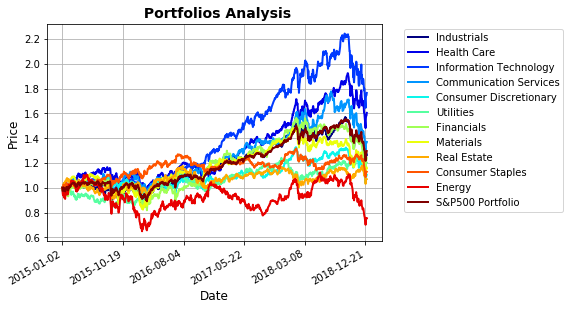

In [64]:
# Plot portfolios mean prices.
pretty_plot(plt.gca(), portfolios)

# Format axis.
nice_formatter(plt.gca(), 'Date', 'Price', ' Portfolios Analysis', legend_out = True)

# Save figure.
savefig(plt.gcf(), section + 'portfolio_analysis' + file_fmt)

# 2 Bond Pricing

## 2.1 Examples of bond pricing

### 2.1.1 Percentage return per annum


An investor received USD 1,100 in one year in return for an investment of USD 1,000 now. Compounding is the operation of adding interest to the initial investment on a rigorous time schedule. Common compounding time-frames that will be overlooked in this example are: annual, semiannual, monthly and continuous. 
Compounding is mathematically computed as follows: 
\begin{equation} \label{eq:compounding_original}
    R = C\left(1+\frac{r}{n}\right)^{nt}
\end{equation}
where $R$ denotes the final sum returned, $C$ is the initial investment, $r$ is the interest rate, $n$ is the
number of times that the interest is applied (compounded) per time period. Finally $t$ denotes the number of time periods elapsed since the investment was made.
Given $n$, the compound return can be inferred as follows:
\begin{equation} \label{eq:compounding}
    r_n = n\left[\left(\frac{R}{C}\right)^{\frac{1}{n}} -1\right]
\end{equation}
Using Equation compounding Equation the various compound returns for the initial example can be computed, i.e. for $ R = 1100 $ and $C = 1000$. Plugging in the given data in the compounding equation gives:
\begin{equation} \label{eq:compounding_plugged}
    r_n = n\left[\left(\frac{1100}{1000}\right)^{\frac{1}{n}} -1\right]
\end{equation}

#### 2.1.1.a Annual Compounding

Plugging $n = 1$ in the equation yields to:
\begin{equation} 
 r_1 = 10 \%
\end{equation}
    
#### 2.1.1.b  Semi-Annual Compounding

   Plugging $n = 2$ in the equation yields to:
    \begin{equation} 
    r_2 = 9.76 \%
    \end{equation}
    
#### 2.1.1.c Monthly Compounding

 Plugging $n = 12$ in the equation yields:
    \begin{equation} 
    r_{12} = 9.57 \%
    \end{equation}
    
#### 2.1.1.d Continuous Compounding

For $n = +\infty$ and recalling the definition of the Euler Number $e$ as :
    \begin{equation} \label{eq:e}
    e = \lim_{i\to \infty}\left(1 + \frac{1}{i}\right)^i
    \end{equation}
    The original compounding equation can be simplified into a more compact exponential form as follows:
    \begin{equation} 
    R_{\infty} = \lim_{i\to \infty}C\left(1+\frac{r}{n}\right)^{nt}
    \end{equation}
    Let $i = \frac{n}{r}$ and substitute into the original equation:
    \begin{equation} 
    R_{\infty} = \lim_{i\to \infty}C\left(1+\frac{1}{i}\right)^{irt} = 
    \lim_{i\to \infty}\left[C\left(1+\frac{1}{i}\right)^{i}\right]^{rt}
    \end{equation}
    Simplify the exponential term to $e$ leveraging the definition of $e$:
    \begin{equation} 
    R_{\infty} = Ce^{rt}
    \end{equation}
    Finally, the equation above can be rearranged to find the continuous compounding interest rate:
    \begin{equation} 
    r_{\infty} = \ln \left(\frac{R}{C}\right)
    \end{equation}
    which ultimately can be used to find the continuous compounding interest rate for the specific example taken into consideration in this section (for $R = 1100$ and $C = 1000$):
    \begin{equation} 
    r_{\infty} = \ln \left(\frac{1100}{1000}\right) = 9.53 \%
    \end{equation}


### 2.1.2 Monthly compounding to continuous


This exercise aims to compute the rate of interest with continuous compounding equivalent to 15% per annum with
monthly compounding.
The equivalence formula between continuous interest rate  and a discrete compounding interest rate of frequency $n$ is:
\begin{equation}
    r_\infty = n \cdot \ln\left(1+\frac{r_n}{n}\right)
\end{equation}
Solving the equation above for a monthly compounding with interest rate 15 %, i.e. $n = 12$ and $r_{12} = 0.15$ gives:
\begin{equation} 
    r_\infty = 12\cdot \ln\left(1+\frac{0.15}{12}\right) = 14.91\%
\end{equation}


### 2.1.3 Quarterly compounding to continuous


This exercise replicates the calculation undertaken in Section 2.1.2 to find the continuous compounding equivalent to an interest rate of 12\% per annum quarterly compounded. 
Therefore, solving again the continuous equation  for the new use-case of quarterly compounding with interest rate 12 \%, i.e. $n = 4$ and $r_{4} = 0.12$ gives:
\begin{equation}
    r_\infty = 4\cdot \ln\left(1+\frac{0.12}{4}\right) = 12.182\%
\end{equation}
Given an initial deposit of $10,000$ USD, the interest received in year will sum up to $r_\infty \cdot 10,000$, i.e. $1,218.18$ USD. In terms of quarterly cashflow, the interest would be paid in 4 occasions, once every three months.


## 2.2 Forward Rates

### 2.2.1 Evaluate and compare forward rates

Suppose that the one–year interest rate, $r_1$ is $5\%$, and the two–year interest rate, $r_2$ is $7\%$. If you invest USD 100 for one year, your investment grows to $100 × 1.05 =$ USD 105; if you invest for two years, it grows
to $100 × 1.072 = $USD 114.49. The extra return that you earn for that second year is $1.072/1.05−1 = 0.090$,
or $9.0 \%$.


#### 2.2.1.a Longer investment's return


The extra return made in the second year is nothing more than the market expectation of what the sport rate will be one year from now. Therefore, assuming that there will be no unexpected developments in the market (i.e. the spot rate will evolve according to predictions), there is no difference in committing to a 2-year investment at the beginning or repeating two-one year investments. However it should be mentioned that average investors do not have an infinite availability of cash, therefore there might be the need for the investor to access said cash sometime during a 2 year time-frame. In this case investing for just one year would give the investor more flexibility into accessing the cash in case of emergencies. 

#### 2.2.1.b Investment strategies analysis


For the market to be arbitrage-free, it must mean that the rates offered for different investment periods are consistent with market expectations and therefore should not impact investors' decisions because they essentially do not constitute any tangible advantage.
On the contrary, the need for liquidity already mentioned in Section 2.2.1.a and the chance of varying investment strategies are important factors to be taken into consideration. In this sense, shorter investments give more opportunities to the investor as they can be cashed out earlier and new investment strategies can be attempted if deemed appropriate.

#### 2.2.1.c Advantages and disadvantages of forward rates

It is clear that taking longer investments is riskier as they span a longer time-frame in which anything could negatively impact the investment. Therefore it is expected that the forward rate $f_{1,2}$ is higher than $r_1$ and $r_2$. Hence assuming that the market conditions stay the same, the forward rate results in higher gains than a two 1-year investment strategy. However, fixing the rate can turn into an advantage or disadvantage based on the market fluctuation during the investment time-frame. 

#### 2.2.1.d Changing the investment period

Using the current spot rate and the implied forward rate defined in the forward rate equation below, the change from a 1-year investment strategy to a 2-year one can be computed.
\begin{equation} \label{eq:forw_rate}
    (1 + r_j)^j = (1 + r_i)^i (1 + f_{i,j})^{j−i}
\end{equation}

## 2.3 Duration of a coupon-bearing bond

### 2.3.1 Duration

Duration is the weighted average of the times to each of the cash payments. The times are the future
years 1, 2, 3, etc., extending to the final maturity date, which we call $T$. The weight for each year is the
present value of the cash flow received at that time divided by the total present value of the bond.

\begin{equation}
  Duration = \sum_{i = 1}^n t_i \frac{PV_i}{V_{tot}}
\end{equation}
where $n$ is the number of payments, $PV_i$ is the present value of the $i$th cash payment, $t_i$ is the years until the $i$th payment is due and $V_{tot}$ is the total present value of the cashflow. 

#### 2.3.1.a  Macaulay duration

For the given data in the table below the last two entries of the Total column have been computed. The Macaulay duration of the 1\% bond is computed as the sum of the last row's elements which amounts to 6.76 years.

In [65]:
# Define and populate table of payment, present value and duration for the given example.

PVk_over_tot = 'PV' + uni['k'][1] + ' / PV' + uni['t'][1] + uni['o'][1] + uni['t'][1]
bonddf = pd.DataFrame(columns=['year 1','year 2','year 3','year 4','year 5','year 6','year 7','Total'])

bonddf.loc['Payment'] = [10,10,10,10,10,10,1010,1070]
bonddf.loc['PV' + uni['k'][1]] = [9.52,9.07,8.64,8.23,7.84,7.46,717.79,768.55]
bonddf.loc[PVk_over_tot] = [0.0124,0.0118,0.0112,0.0107,0.0102,0.0097,0.0934,1]
bonddf.loc['t' + uni['k'][1] + ' * ' + PVk_over_tot] = [0.0124,0.0236,0.0337,0.0428,
                                                        0.0510,0.0583,6.5377,6.7595]

In [66]:
display(bonddf)

year 1  year 2  year 3  year 4  year 5  year 6  year 7  \
Payment               10      10      10      10      10      10    1010   
PVₖ                 9.52    9.07    8.64    8.23    7.84    7.46  717.79   
PVₖ / PVₜₒₜ       0.0124  0.0118  0.0112  0.0107  0.0102  0.0097  0.0934   
tₖ * PVₖ / PVₜₒₜ  0.0124  0.0236  0.0337  0.0428   0.051  0.0583  6.5377   

                   Total  
Payment             1070  
PVₖ               768.55  
PVₖ / PVₜₒₜ          1.0  
tₖ * PVₖ / PVₜₒₜ  6.7595

#### 2.3.1.b  Modified duration



$D_m$ is the modified duration, another statistic of bonds. It is defined as the derivative of the Macaulay duration with respect to the yield $\lambda$:
\begin{equation}
    D_m = \frac{1}{P(\lambda_0)}\frac{dP(\lambda)}{d\lambda} \; for \; \lambda = \lambda_0
\end{equation}

Modified duration is a measure of risk, as it quantifies how sensitive the duration is to changes in the yield, i.e. how much a variation in the interest rates causes a change of price of the bond. It can be mathematically proved that the two durations are linked by the relationship
$D_m = \frac{D}{1+ \frac{\lambda}{m}}$,
where $m$ is the amount of yearly compounding intervals, so $m = 1$ for yearly compounding. For continuous compounding instead, $m = \infty$ which yields to the two durations be exactly equivalent $D_m = D$.
In the specific example taken into consideration in this section the given yield is 5\%, and
$m = 1$. Therefore $D_m = 6.438\%$.

#### 2.3.1.c  Advantages of duration against volatility

A long-term investment is characterised by a larger duration than a bond with shorter time to maturity. A larger duration implies a greater impact of changes in interest rate, as more coupon payments are due in the future in the scenario of a pension plan. 
As discussed in Section 2.3.1.b, the modified duration gives a measure of the riskiness of the bond. 
Both measures give the investor information on changes on interest rates and therefore are useful in assessing the market status and predicting sudden changes to protect the pension plan. The technique that leverages statistics such as Duration and Convexity to design a robust portfolio against volatility is called immunisation and consists in matching the aforementioned statistics which mathematically map Taylor's series terms.

## 2.4 Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

### 2.4.1 Equally-weighted market return estimation

In [67]:
# Define path to save pictures.
section = "img/sec2/2.4/"

In [68]:
# retrieve dataframe.
df = pd.read_csv(data_folder + 'fsp_case_31_BSD.csv', index_col = 0, header = [0 ,1]) 

# Pre-process returns data.
returns = df['ret'].copy().dropna(1) # simple data pre-processing
returns.index = pd.to_datetime(returns.index) # Seth the index to date time type
returns = returns.sort_index() # sort by time
mark_return_non_weighted = returns.mean(1) # market equally-weighted returns

----------------------------------
Market return mean : 	 4.7202529233198694e-05
Market return std : 	 0.006650324555998093
----------------------------------


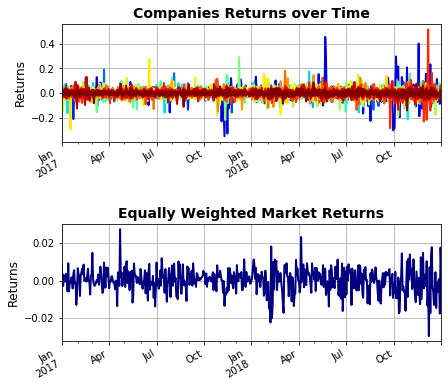

In [69]:
# Initialise subplot.
fig, axes = subplot_init(2,1, fig_size = (5, 6), hspace = 0.7)

# Plot company returns and format axis.
pretty_plot(axes[0], returns)
nice_formatter(axes[0], ylabel = 'Returns', title = 'Companies Returns over Time', legend_on = False)

# Plot equally-weighted returns and format axis.
pretty_plot(axes[1], mark_return_non_weighted)
nice_formatter(axes[1], ylabel = 'Returns', title = 'Equally Weighted Market Returns', legend_on = False)

# Compute and plot market statistics..
market_mean = mark_return_non_weighted.mean()
market_std = mark_return_non_weighted.std()
pretty_print((market_mean, market_std), 
             ('Market return mean', 'Market return std'))

# Save figure.
savefig(fig, section + 'all_returns' + file_fmt)


### 2.4.2 Equally-weighted rolling beta estimation

In [70]:
# Define window size.
w = 22 

In [71]:
# Define equally weighted returns and betas.
all_ret_non_weighted = returns.copy() 
all_ret_non_weighted['market'] = mark_return_non_weighted.copy()

betadf_non_weighted = pd.DataFrame(columns = all_ret_non_weighted.columns) 

In [72]:
for t in all_ret_non_weighted.index[(w-1):]: 
    # For each time step calculate covariance matrix and betas.
    ret_C = all_ret_non_weighted[:t].iloc[-w:].cov() 
    curr_betas = ret_C['market'] / ret_C['market']['market']
    
    # Save betas into dataframe.
    betadf_non_weighted.loc[t] = curr_betas

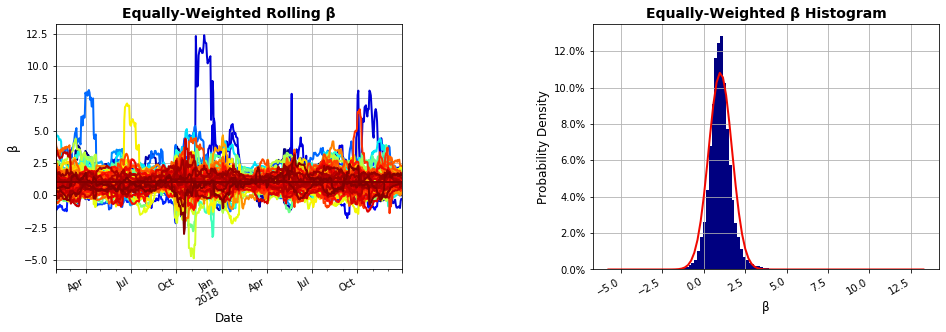

In [73]:
# Initialise subplot.
fig, axes = subplot_init(1, 2, fig_size = (4, 13))

# Print rolling beta and format axis.
pretty_plot(axes[0], betadf_non_weighted)
nice_formatter(axes[0], 'Date', sub[':beta'], 'Equally-Weighted Rolling '+ sub[':beta'], legend_on = False)

# Print the betas PDF in a histogram and format axis.
hist_plot(axes[1], betadf_non_weighted.values.reshape(-1))
nice_formatter(axes[1], sub[':beta'], 'Probability Density', 'Equally-Weighted ' + sub[':beta'] + ' Histogram', legend_on = False)

# Save figure.
savefig(fig, section + 'roll_beta' + file_fmt)

In [74]:
# Print beta mean and std.
pretty_print((np.mean(betadf_non_weighted.values.reshape(-1)), 
              np.std(betadf_non_weighted.values.reshape(-1))), ('mean ' + sub[':beta'], 'std ' + sub[':beta']))

----------------------------------
mean β : 	 1.0
std β : 	 0.708104366971137
----------------------------------


### 2.4.3 Market-cap-weighted market return estimation

In [75]:
# Retrieve the market caps.
market_cap = df['mcap'].copy() 
market_cap.index = pd.to_datetime(market_cap.index) 
market_cap = market_cap[returns.columns]

# Compute the weights based on the market cap.
weights = market_cap.divide(market_cap.sum(1), 0)

# Compute the weighted market return.
weighted_returns = weights * returns.copy()
weighted_market_return = weighted_returns.sum(1)

----------------------------------
Market return mean : 	 0.00018841990142144148
Market return std : 	 0.006599318685834848
----------------------------------


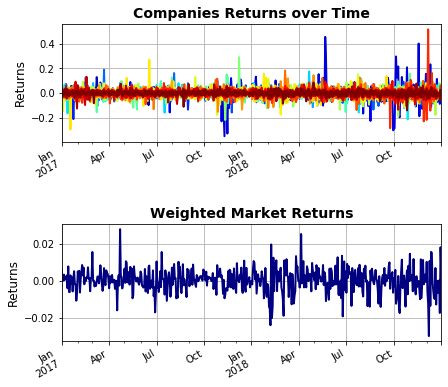

In [76]:
# Initialise subplot.
fig, axes = subplot_init(2, 1, fig_size = (5, 6), hspace = 0.7)

# Plot company returns and format axis.
pretty_plot(axes[0], returns)
nice_formatter(axes[0], ylabel = 'Returns', title = 'Companies Returns over Time', legend_on = False)

# Plot weighted market returns and format axis.
pretty_plot(axes[1], weighted_market_return)
nice_formatter(axes[1], ylabel = 'Returns', title = 'Weighted Market Returns', legend_on = False)

# Compute and print statistics of the market.
market_mean = weighted_market_return.mean()
market_std = weighted_market_return.std()
pretty_print((market_mean, market_std), ('Market return mean', 'Market return std'))

# Save figure.
savefig(fig, section + 'weighted_all_returns' + file_fmt)

### 2.4.4 Market-cap-weighted rolling beta estimation

In [77]:
# Define window size.
w = 22

In [78]:
# Recopy returns and populate betas dataframe
returns_matrix = returns.copy()
returns_matrix['market'] = weighted_market_return.copy() 

betadf_weights = pd.DataFrame(columns = returns_matrix.columns) 

for t in returns_matrix.index[w-1:]: 
    # At each time step compute covariance matrix and betas.
    ret_C = returns_matrix[:t].iloc[-w:].cov() 
    curr_betas = ret_C['market'] / ret_C['market']['market'] 
    
    # Save beta into dataframe.
    betadf_weights.loc[t] = curr_betas

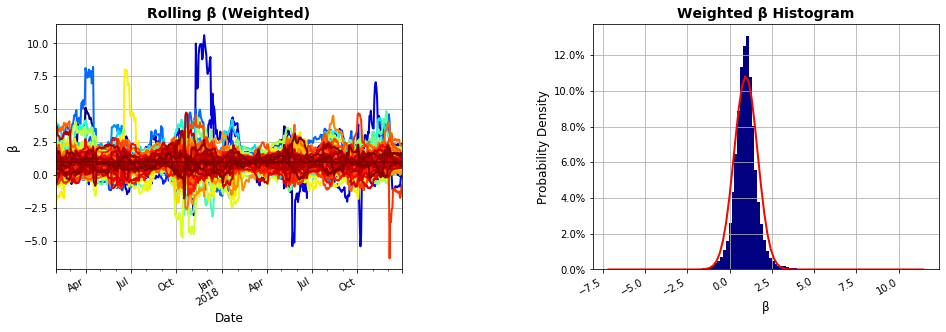

In [79]:
# Initialise subplot.
fig, axes = subplot_init(1, 2, fig_size = (4, 13))

# Plot rolling beta and format axis.
pretty_plot(axes[0], betadf_weights)
nice_formatter(axes[0], 'Date', sub[':beta'], 'Rolling ' + sub[':beta'] + ' (Weighted)', legend_on = False)

# Plot PDF of rolling beta in histogram form and format axis.
hist_plot(axes[1], betadf_weights.values.reshape(-1))
nice_formatter(axes[1], sub[':beta'], 'Probability Density', 
               'Weighted ' + sub[':beta'] + ' Histogram', legend_on = False)

# Save figure.
savefig(fig, section + 'weighted_roll_beta' + file_fmt)

In [80]:
# Print mean beta and std.
pretty_print((np.mean(betadf_weights.values.reshape(-1)), 
              np.std(betadf_weights.values.reshape(-1))), ('mean ' + sub[':beta'], 'std ' + sub[':beta']))

----------------------------------
mean β : 	 0.9616577418388089
std β : 	 0.6940217680471462
----------------------------------


### 2.4.5. Arbitrage pricing theory

#### 2.4.5.a Estimate factor returns


In [81]:
# Copy returns and define beta of market.
returns_copy = returns.copy() 
returns_copy = returns_copy.loc[betadf_weights.index] 

beta_market = betadf_weights.iloc[:, :-1] 

beta_size = np.log(market_cap.loc[betadf_weights.index])

In [82]:
# Initialize the Rm, Rs, a and e matrices.
Rm = pd.Series(index = returns_copy.index, dtype='float64')
Rs = pd.Series(index = returns_copy.index, dtype='float64')
a = pd.Series(index = returns_copy.index, dtype='float64')
e = pd.DataFrame(index = returns_copy.index, columns = returns_copy.columns)

for t in returns_copy.index: 
    # At each time frame compute current return, market beta and beta size.
    curr_r = returns_copy.loc[t].values.reshape(-1,1)
    curr_beta_market = beta_market.loc[t].values.reshape(-1,1)
    curr_beta_size = beta_size.loc[t].values.reshape(-1,1)
    
    # Compute M and b.
    one_matrix = np.ones((curr_beta_market.shape))
    M = np.hstack((one_matrix, curr_beta_market, curr_beta_size))
    b = (np.linalg.inv(M.T @ M) @ M.T) @ curr_r
    
    # save current values for Rm, Rs, a and e.
    Rm[t] = float(b[1])
    Rs[t] = float(b[2])
    a[t] = float(b[0])
    e.loc[t] = (curr_r - M @ b).reshape(1,-1)

#### 2.4.5.b Variance and magnitude of parameters

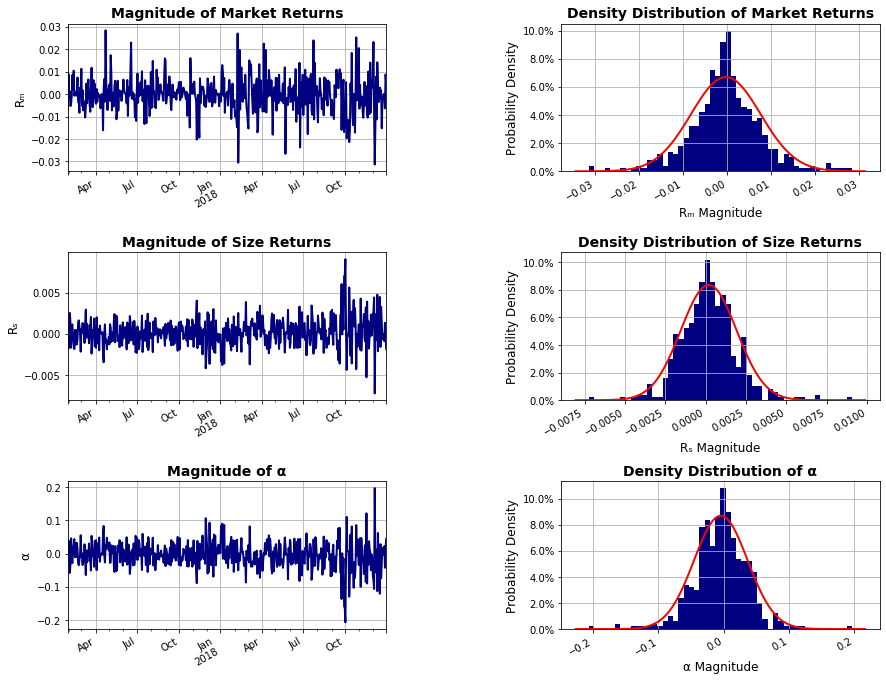

In [83]:
# Initialise subplot.
fig, axes = subplot_init(3,2, fig_size = (9, 12))

# Plot and format Rm, Rs, and a.
pretty_plot(axes[0][0], Rm)
nice_formatter(axes[0][0], ylabel = 'R' + uni['m'][1], title = 'Magnitude of Market Returns', legend_on = False)

pretty_plot(axes[1][0], Rs)
nice_formatter(axes[1][0], ylabel = 'R' + uni['s'][1], title = 'Magnitude of Size Returns', legend_on = False)

pretty_plot(axes[2][0], a)
nice_formatter(axes[2][0], ylabel = sub[':alpha'], 
               title = 'Magnitude of ' + sub[':alpha'], legend_on = False)


# Plot PDFs for parameters.
hist_plot(axes[0][1], Rm, bins = 50)
nice_formatter(axes[0][1], 'R' + uni['m'][1] + ' Magnitude', 'Probability Density', 
               title = 'Density Distribution of Market Returns', legend_on = False)

hist_plot(axes[1][1], Rs, bins = 50)
nice_formatter(axes[1][1], 'R' + uni['s'][1] + ' Magnitude', 'Probability Density', 
               title = 'Density Distribution of Size Returns', legend_on = False)

hist_plot(axes[2][1], a, bins = 50)
nice_formatter(axes[2][1], sub[':alpha'] + ' Magnitude', 'Probability Density',
               title = 'Density Distribution of ' + sub[':alpha'], legend_on = False)


# Save figure.
savefig(fig, section + 'market_size_returns' + file_fmt)

#### 2.4.5.c Specific return

----------------------------------
corr mean : 	 0.811491895352188
corr std : 	 0.07592528090185027
----------------------------------


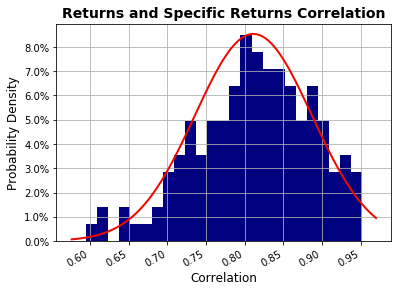

In [84]:
# Compute the return and specific return correlation.
specific_ret_corr = pd.Series(index = e.columns, dtype = 'float64')

for company in e.columns:
    specific_ret_corr[company] = pearsonr(e[company], returns_copy[company])[0]

    
# Plot the return and specific return correlation PDF.
hist_plot(plt.gca(), specific_ret_corr, bins = 25)

nice_formatter(plt.gca(), 'Correlation', 'Probability Density', 
               'Returns and Specific Returns Correlation', legend_on = False)


# Print the mean and variance of the correlation.
pretty_print((specific_ret_corr.mean(), specific_ret_corr.std()), ('corr mean', 'corr std'))

# Save figure.
savefig(plt.gcf(), section + 'returns_corr' + file_fmt)

#### 2.4.5.d Covariance matrix stability analysis

In [85]:
# Define window size.
w = 22

In [86]:
# Build dataframe R.
R = pd.DataFrame(columns=['Rm', 'Rs'])
R['Rm']= Rm
R['Rs']= Rs

# Initialise log of R covariance.
log_R_cov = []

# Save R covariances on a rolling base.
for t in R.index[(w-1):]:
    curr_R = R[:t].iloc[-w:]
    curr_R_cov = np.cov(curr_R.T)
    log_R_cov.append(curr_R_cov)

log_R_cov = np.array(log_R_cov)

# Compute rolling magnitude and stability.
rolling_magnitude = pd.Series(index = R.index[(w-1):], dtype = 'float')
rolling_stability = pd.Series(index = R.index[(w-1):], dtype = 'float')

for i in range(1, log_R_cov.shape[0]):
    # Magnitude.
    curr_R_cov = log_R_cov[i]
    rolling_magnitude[i] = (np.linalg.norm(curr_R_cov))
    
    # Stability. 
    prev_R_cov = log_R_cov[i-1]
    rolling_stability[i] = (100 * np.mean(abs((curr_R_cov - prev_R_cov) / prev_R_cov)))


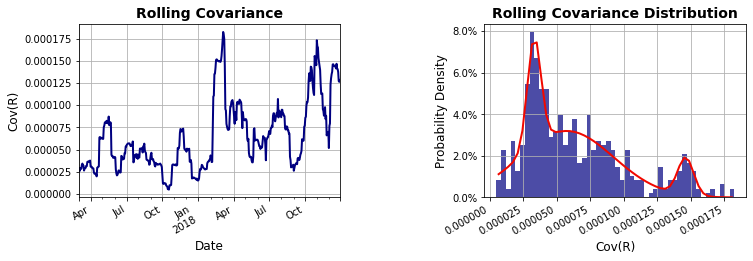

In [101]:
# Initialise subplot.
fig, axes = subplot_init(1, 2, fig_size = (3, 10))

# Plot rolling covariance magnitude.
pretty_plot(axes[0], rolling_magnitude)
nice_formatter(axes[0], 'Date', 'Cov(R)', 'Rolling Covariance', legend_on = False)


# Plot multimodal price histograms with PDFs.
expected = (10, 0.000025, 0.00003, 5, 0.000090, 0.00005, 5, 0.00015, 0.000004)
hist_plot_multimodal(axes[1], rolling_magnitude.dropna().to_numpy(), expected, bins = 50,
                     color1 = CMAP_OBJ(0), color2 = CMAP_OBJ(0.9))


nice_formatter(axes[1], 'Cov(R)', 'Probability Density', 
               'Rolling Covariance Distribution', legend_on = False)

# Save figure.
savefig(plt.gcf(), section + 'roll_cov' + file_fmt)

#### 2.4.5.e Principal component analysis (PCA)

In [88]:
# Compute eigenvalues and eigenvectors.
eigvals, eigvecs = np.linalg.eigh(e.astype(float).cov())

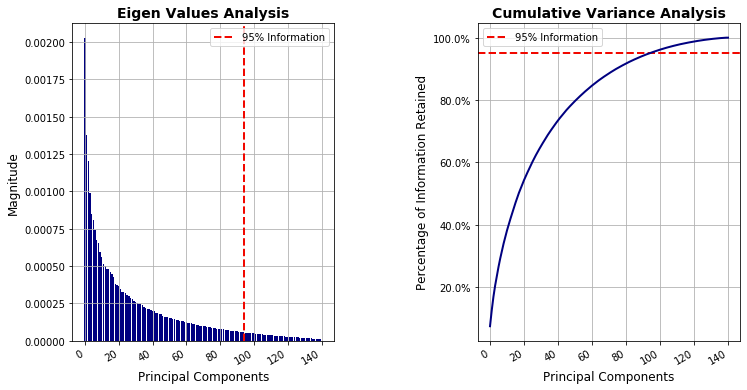

In [89]:
# Initialise subplot.
fig, axes = subplot_init(1, 2, fig_size = (5, 10))

# Format eigenvalues and compute cumulative variance.
eigvals = eigvals[::-1]
cum_exp_var = np.cumsum(eigvals/sum(eigvals) * 100)

# Scree Plot and 95% threshold.
axes[0].bar(np.arange(len(eigvals)), eigvals.T, color = CMAP_OBJ(0))
axes[0].axvline(x = 94, linestyle = '--', linewidth = 2, color = CMAP_OBJ(0.9), label = '95% Information')
nice_formatter(axes[0], xlabel = 'Principal Components', ylabel = 'Magnitude', title = 'Eigen Values Analysis')

# Cumulative Variance and 95% threshold.
axes[1].axhline(y = 95, linestyle = '--', linewidth = 2, color = CMAP_OBJ(0.9), label = '95% Information')
pretty_plot(axes[1], cum_exp_var)
nice_formatter(axes[1], xlabel = 'Principal Components', ylabel = 'Percentage of Information Retained', 
               title = 'Cumulative Variance Analysis')

# Set ticks to percentages.
vals = axes[1].get_yticks() / 100
axes[1].set_yticklabels(['{:,.1%}'.format(x) for x in vals])

# Save figure.
savefig(plt.gcf(), section + 'ordered_evals' + file_fmt)

# 3. Portfolio Optimisation

## 3.1 Adaptive Minumum-Variance Portfolio Optimization

### 3.1.1 Optimal weights

In [90]:
# Path to save figures.
section = 'img/sec3/3.1/'

This section will discuss how to optimise the portfolio for minimum-variance, i.e. find the best rate of return for the minimum risk, as mathematically formulated in the the equation below:

\begin{equation} \label{eq:opt_weights}
    \min_{\boldsymbol{w}} J(\boldsymbol{w}, \boldsymbol{C}) = \frac{1}{2} \boldsymbol{w}^T\boldsymbol{C}\boldsymbol{w}
\end{equation}

\begin{equation*} \
    \text{subject to: } \boldsymbol{w}^T\boldsymbol{1} = 1
\end{equation*}

where $\boldsymbol{w}$ is the weights vector, $\boldsymbol{C}$ is the covariance matrix of all assets and the expected return and variance of the portfolio are defined as:

\begin{equation}
    \bar{\mu} = \boldsymbol{w}^T\boldsymbol{\mu}  \;\;\; \text{and} \;\;\; \bar{\sigma}^2 =  \boldsymbol{w}^T\boldsymbol{C}\boldsymbol{w}
\end{equation}


To solve the minimisation task, the Langrangian is differentiated with respect to $\lambda$ and with respect to the weight vector $\boldsymbol{w}$, then both derivatives are set to zero to compute the parameters value at optimality. 
It should be mentioned that $\boldsymbol{C}$ is symmetric, hence there is no difference between the covariance matrix and its transpose. It is also assumed to be invertible, and $\boldsymbol{C^{-1}}$ will also be equivalent to its transpose.
Finally, the weights $\boldsymbol{w}$ are not assumed to be non-negative, which physically means that shorting is allowed. However, the average investor often does not have the option to short assets, so in order to accommodate this extra constraint should be added in the optimisation problem.
The derivative of the Lagrangian $L$ with respect to the weights is:

\begin{equation}
    \frac{\partial L}{\partial \boldsymbol{w}} = \boldsymbol{C}\boldsymbol{w}^* - \lambda\boldsymbol{1}
\end{equation}

where $\boldsymbol{w}^*$ denotes the optimal set of weights. Setting the derivative to zero and rearranging it yields:

\begin{equation} \label{eq:w_opt}
    \boldsymbol{w}^* = \lambda \boldsymbol{C}^{-1} \boldsymbol{1} 
\end{equation}

Differentiating with respect to the Lagrangian parameter $\lambda$ gives:

\begin{equation}
    \frac{\partial L}{\partial \lambda} = (\boldsymbol{w}^{*T}\boldsymbol{1} - 1)
\end{equation}

Which is then set to zero and rearranged to:

\begin{equation} \label{eq:w_opt2}
    \boldsymbol{w}^{*T}\boldsymbol{1} = 1
\end{equation}

The equation above can be substituted in the first equation by performing some matrix manipulations on the latter as follows:

\begin{equation}
    \boldsymbol{w}^{*T}\boldsymbol{1}  = \lambda \boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1} 
\end{equation}

and finally carrying the substitution to obtain:

\begin{equation} \label{eq:lambda_unprocessed}
    \lambda \boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1} = 1 
\end{equation}

From the equation above, the value of $\lambda$ can be retrieved and it is defined by:

\begin{equation} \label{eq:lambda}
    \lambda = \frac{1}{\boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1}}
\end{equation}

which can be substituted back in the optimal weights definition in the first equation of the section to get:

\begin{equation} \label{eq:final_w_opt}
    \boldsymbol{w}^{*} = \frac{\boldsymbol{C}^{-1} \boldsymbol{1}}{\boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1}}
\end{equation}

Having computed the optimal set of weights, they can simply be plugged into the equations for the expected mean return and variance of the portfolio defined in Section 3.1 to obtain the theoretical return and variance of the minimum-variance portfolio, which are the following:

\begin{equation}
    \bar{\mu}^* = \boldsymbol{w}^{*T}\boldsymbol{\mu} =  
        \frac{\boldsymbol{C}^{-1} \boldsymbol{1}}{\boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1}} \boldsymbol{\mu}
\end{equation}

\begin{equation} \label{eq:theor_var}
    (\bar{\sigma}^{2})^* = \boldsymbol{w}^{*T}\boldsymbol{C}\boldsymbol{w}^* = 
    \frac{1}{\boldsymbol{1}^T \boldsymbol{C}^{-1} \boldsymbol{1}}
\end{equation}

### 3.1.2 Minimum-variance portfolio analysis 

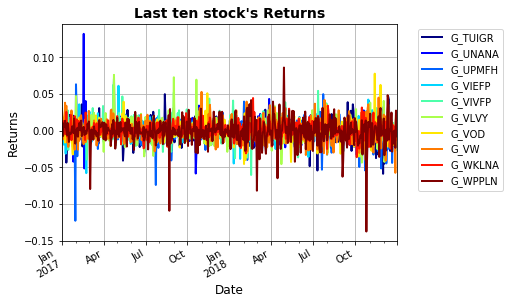

In [91]:
# Retrieve returns data.
df = pd.read_csv(data_folder + 'fsp_case_31_BSD.csv', index_col = 0, header = [0 ,1]) 
returns = df['ret'].copy().dropna(1) 
returns.index = pd.to_datetime(returns.index) 
returns = returns.iloc[:, -10:]

# Plot 10 returns data.
pretty_plot(plt.gca(), returns)
nice_formatter(plt.gca(), 'Date', 'Returns', 'Last ten stock\'s Returns', 
               display_names = returns.columns, legend_out = True)

# Split train-test.
half_split = int(returns.shape[0] / 2)
returns_train = returns.iloc[:half_split, :]
returns_test = returns.iloc[half_split:, :]

# Save figure.
savefig(plt.gcf(), section + '10_returns' + file_fmt)

In [92]:
# Define portfolio stats dataframe.
portfolio_analysis = pd.DataFrame(index = ['Equally Weighted Train', 'Minimum Variance Train',
                                           'Equally Weighted Test', 'Minimum Variance Test'], 
                                  columns = ['Mean Return', 'Cumulative Return', 
                                             'Variance', 'Theoretical Variance'])

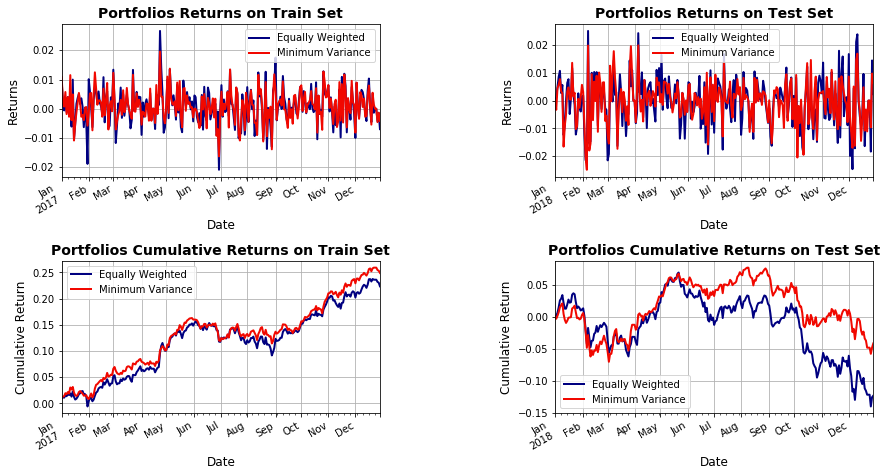

In [93]:
# Initialise subplot.
fig, axes = subplot_init(2, 2, fig_size = (6, 12))

# Axes index.
i = 0

# For both train and test.
for portfolio in (returns_train.mean(1), returns_test.mean(1)):
    
    # Plot portfolio returns and cumulative sum.
    pretty_plot(axes[0][i], portfolio, label = "Equally Weighted")
    pretty_plot(axes[1][i], portfolio.cumsum(), label = "Equally Weighted")
    
    # cases if train or test.
    if i == 0:
        rets = returns_train
        tset = 'Train'
    else:
        rets = returns_test
        tset = 'Test'

    
    # compute covariance and weights.
    C = rets.cov()
    opt_weights = get_opt_weights(C, rets)
    min_var = (rets * opt_weights).sum(1)
    
    # Equally weighted portfolio statistics.
    equally_weighted_stats = portfolio_stats(portfolio) + ['-']
    portfolio_analysis.iloc[2 * i, :] =  equally_weighted_stats
    one_matrix = np.ones((opt_weights.shape)).reshape(-1, 1)
    theor_var = 1 / (one_matrix.T @ np.linalg.inv(C).T @ one_matrix)
    
    # Min-var portfolio statistics.
    min_var_stats = portfolio_stats(min_var) + [str(round(theor_var[0,0], 10))]
    portfolio_analysis.iloc[2 * i + 1, :] = min_var_stats

    # Plot minimum variance returns and cumulative sum.
    pretty_plot(axes[0][i], min_var, color = CMAP_OBJ(0.9), label = "Minimum Variance")
    pretty_plot(axes[1][i], min_var.cumsum(), color = CMAP_OBJ(0.9), label = "Minimum Variance")

    # Format axes.
    nice_formatter(axes[0][i], 'Date', 'Returns',  'Portfolios Returns on ' + tset + ' Set')
    nice_formatter(axes[1][i], 'Date', 'Cumulative Return', 'Portfolios Cumulative Returns on ' + tset + ' Set')
    i += 1
    
# Save figure.
savefig(fig, section + 'EW_min_var_analysis' + file_fmt)

In [94]:
display(portfolio_analysis)

Mean Return Cumulative Return     Variance  \
Equally Weighted Train   0.0008595546         0.2234842   3.7495e-05   
Minimum Variance Train   0.0009579316      0.2490622063  2.86163e-05   
Equally Weighted Test   -0.0004731904        -0.1235027  7.93339e-05   
Minimum Variance Test   -0.0001602424     -0.0418232764  5.84487e-05   

                       Theoretical Variance  
Equally Weighted Train                    -  
Minimum Variance Train          2.86163e-05  
Equally Weighted Test                     -  
Minimum Variance Test           5.84487e-05

### 3.1.3 Adaptive minimum-variance portfolio analysis

In [95]:
# Initialise window size and other variables.
windows =  [22 * i for i in [1, 4, 8, 12]]
rets = []
variances = []
cum_returns = []
colors = [0, .3, .5, .8]

i = 0

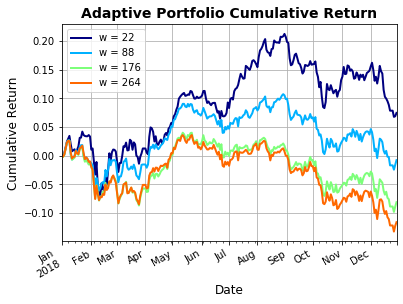

In [96]:
# For all analysed windows.
for w in windows:  
    
    # Initialise portfolio and logging variables.
    adapt_min_var_portfolio = pd.Series(dtype = 'float64') 
    log_opt_weights = [] 
    log_returns = []
    
    # For each timestep.
    for t in returns_test.index: 
        # Compute current return, covariance and weights.
        curr_return = returns[:t].iloc[(-w-1):-1] 
        curr_C = curr_return.cov() 
        opt_weights = get_opt_weights(curr_C, curr_return) 
        
        # Store weights, returns and portfolio performance.
        log_opt_weights.append(opt_weights)
        adapt_min_var_portfolio[t] = sum(returns_test.loc[t] * opt_weights)  
        log_returns.append(adapt_min_var_portfolio[t])
        
    # Log returns and variances.
    rets.append(log_returns)
    variances.append(adapt_min_var_portfolio.std() ** 2)
    
    # Plot cumulative returns and format axes.
    pretty_plot(plt.gca(), adapt_min_var_portfolio.cumsum(), color = CMAP_OBJ(colors[i]),
                label = 'w = ' + str(windows[i]))
    nice_formatter(plt.gca(), 'Date', 'Cumulative Return', 'Adaptive Portfolio Cumulative Return')
   
    i += 1

# Save figure.
savefig(plt.gcf(), section + 'adapt_cumulative_return' + file_fmt)

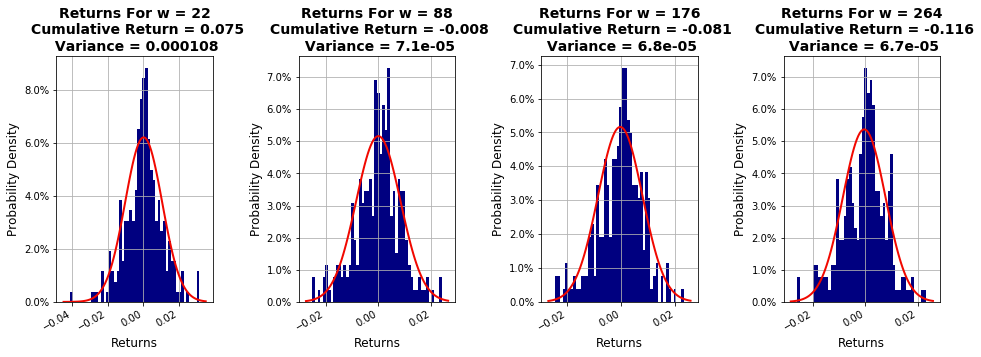

In [97]:
# Initialise subplot.
fig, axes = subplot_init(1, 4, fig_size = (4, 13))

# For all windows.
for i in range(len(windows)):
    
    # Define title of the figure.
    text = "\n Cumulative Return = " + str(round(sum(rets[i]), 3)) + \
            "\n Variance = " + str(round(variances[i], 6))
    
    # Plot histograms for cumulative returns.
    hist_plot(axes[i], rets[i], bins = 50)
    nice_formatter(axes[i], 'Returns', 'Probability Density', 
                   'Returns For w = ' + str(windows[i]) + text, legend_on = False)

# Save figure.
savefig(fig, section + 'adapt_returns_analysis' + file_fmt)

# 4 Robust Statistics and Non-Linear Methods

## 4.1 Data Import and Exploratory Data Analysis

In [98]:
section = 'img/sec4/4.1/'

### 4.1.1 Key descriptive statistics

In [99]:
# Read price data for AAPL, IBM, JPM and DJI.
AAPL = pd.read_csv(data_folder + 'AAPL.csv', index_col = 0) 
AAPL.index = pd.to_datetime(AAPL.index) 

IBM = pd.read_csv(data_folder + 'IBM.csv', index_col = 0)
IBM.index = pd.to_datetime(IBM.index)

JPM = pd.read_csv(data_folder + 'JPM.csv', index_col = 0)
JPM.index = pd.to_datetime(JPM.index)

DJI = pd.read_csv(data_folder + 'DJI.csv', index_col = 0)
DJI.index = pd.to_datetime(DJI.index)

all_stocks = {'AAPL': AAPL, 'IBM': IBM, 'JPM': JPM, 'DJI': DJI} 

In [108]:
# Variables initialisations.
tickers = ['AAPL', 'IBM', 'JPM', 'DJI'] 
dtypes = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] 
stats = ['Mean', 'Median', 'StdDev', 'MAD', 'IQR', 'Skew', 'Kurtosis'] 
statistics_df = pd.DataFrame(index = stats, columns = dtypes) 

all_statistics = {'AAPL': statistics_df.copy(), 'IBM': statistics_df.copy(), 
                  'JPM': statistics_df.copy(), 'DJI': statistics_df.copy()} 

In [110]:
# For each stock data.
for ticker in tickers:
    
    # Read data of the specific stock-index.
    data = all_stocks[ticker].copy()
    
    # For each data type.
    for dtype in dtypes:
        col = data[dtype]
        
        # Compute all the statistics.
        all_statistics[ticker][dtype]['Mean'] = col.mean()
        all_statistics[ticker][dtype]['Median'] = col.median()
        all_statistics[ticker][dtype]['StdDev'] = col.std()
        all_statistics[ticker][dtype]['MAD'] = mad_c(col, c = 1)
        all_statistics[ticker][dtype]['IQR'] = iqr(col)
        all_statistics[ticker][dtype]['Skew'] = col.skew()
        all_statistics[ticker][dtype]['Kurtosis'] = col.kurtosis()

In [111]:
# Print all statistics.
i = 0
for ticker in tickers:
    print("\n\033[1m" + ticker + "\033[0m")
    display(all_statistics[ticker])


AAPL


Open        High         Low       Close   Adj Close  \
Mean      187.686694  189.561753  185.823705  187.711953  186.174273   
Median    186.289993  187.399994  184.940002  186.119995  184.351776   
StdDev     22.145621   22.281577   22.008797   22.160721   21.904664   
MAD        15.889999   15.610001   15.919998   15.940002   15.476044   
IQR             36.0   36.339996   36.059998   36.755004    35.68544   
Skew        0.259917    0.300385    0.220489    0.263849     0.29077   
Kurtosis   -0.912594   -0.924602   -0.917632   -0.932425   -0.928017   

                   Volume  
Mean      32704750.199203  
Median         29184000.0  
StdDev    14179721.592994  
MAD             7573900.0  
IQR            16311700.0  
Skew             1.743317  
Kurtosis         4.353182


IBM


Open        High         Low       Close   Adj Close  \
Mean      138.454382  139.492072  137.329243  138.363108  134.902751   
Median    142.809998  143.990005  142.059998  142.710007  138.566391   
StdDev     12.114308   11.913079   12.204633   12.028123   10.671648   
MAD         5.270004    5.309998    5.190002    5.230011    4.493515   
IQR        15.379998   14.720001   16.340004   15.504997   14.103938   
Skew       -0.676024   -0.622707   -0.713446   -0.682246   -0.811222   
Kurtosis   -0.585272   -0.623607   -0.561975   -0.584037   -0.420852   

                  Volume  
Mean      5198937.450199  
Median         4237900.0  
StdDev    3328955.530426  
MAD             920700.0  
IQR            1952950.0  
Skew            3.192896  
Kurtosis       11.796897


JPM


Open        High         Low       Close   Adj Close  \
Mean      108.707689  109.652072  107.682988  108.606574   107.26259   
Median        109.18  110.529999  107.790001  109.019997  107.219269   
StdDev      5.359081     5.20287    5.432537     5.30048    4.833316   
MAD         4.470001    4.309997    4.239998    4.350006    3.450157   
IQR         8.810006    8.845002    8.845001    8.834999    7.222442   
Skew       -0.420811   -0.376221   -0.377517   -0.374853   -0.344491   
Kurtosis   -0.322536   -0.544163     -0.2657   -0.396579   -0.105437   

                   Volume  
Mean      14700689.243028  
Median         13633000.0  
StdDev     5349770.564456  
MAD             3035400.0  
IQR             6233600.0  
Skew             1.693457  
Kurtosis         4.430197


DJI


Open          High           Low         Close  \
Mean      25001.257268  25142.041965  24846.002226  24999.153581   
Median    25025.580078  25124.099609  24883.039063  25044.289063   
StdDev      858.834708    815.203959    903.302186    859.132105   
MAD         543.541015     537.61914     601.56836    590.720703   
IQR         1109.43457   1077.816406   1204.418945   1158.155273   
Skew         -0.372127     -0.239367     -0.456447     -0.380147   
Kurtosis      0.485736      0.118153      0.557592      0.400668   

             Adj Close            Volume  
Mean      24999.153581  332889442.231076  
Median    25044.289063       313790000.0  
StdDev      859.132105    94078038.14115  
MAD         590.720703        50460000.0  
IQR        1158.155273       108930000.0  
Skew         -0.380147           1.73956  
Kurtosis      0.400668          5.857581

In [112]:
# Compute return from Adj Close for each ticker.
for ticker in tickers:
    all_stocks[ticker]['Returns'] = all_stocks[ticker]['Adj Close'].pct_change()

### 4.1.2 Probability density functions (PDF)

In [113]:
# Define roughly expected means and std for stocks and return gaussian components.
stock_expected = [
                  (25, 170, 10, 30, 188, 3, 7, 218, 15),
                  (10, 140, 5, 5, 115, 5, 0, 0, 0),
                  (40, 110, 3, 30, 117, 2, 0, 0, 0)
                  ]

returns_expected = [
                   (5, 0, 0.2, 0, 0, 0, 0, 0, 0),
                   (4, 0, 0.2, 0, 0, 0, 0, 0, 0),
                   (3, 0, 0.2, 0, 0, 0, 0, 0, 0),
                  ]

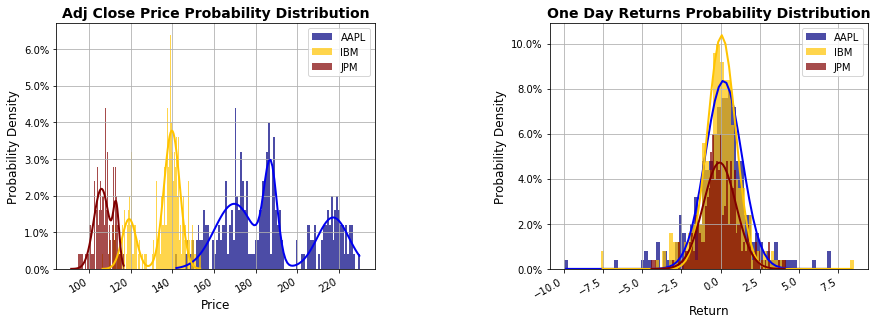

In [114]:
# Initialise subplot.
fig, axes = subplot_init(1, 2, fig_size = (4, 12))   

# For the three stocks.
for i in range(len(tickers) - 1):
    
    # Retrieve price data.
    price_data = all_stocks[tickers[i]]['Adj Close'].dropna()   
    
    # Plot multimodal price histograms with PDFs.
    hist_plot_multimodal(axes[0], price_data.to_numpy(), stock_expected[i], bins = 100,
                         color1 = CMAP_OBJ(0 + 0.7 * i), color2 = CMAP_OBJ(0.1 + 0.6 * i), label = tickers[i])

    nice_formatter(axes[0], 'Price', 'Probability Density', 'Adj Close Price Probability Distribution')
    
    
    # Retrieve returns data.
    returns_data = 100 * all_stocks[tickers[i]]['Returns'].dropna()
    
    # Plot multimodal returns histograms with PDFs.
    hist_plot_multimodal(axes[1], returns_data.to_numpy(), returns_expected[i], bins = 70,
                     color1 = CMAP_OBJ(0 + 0.7 * i), color2 = CMAP_OBJ(0.1 + 0.6 * i), label = tickers[i])
    
    nice_formatter(axes[1], 'Return', 'Probability Density', 'One Day Returns Probability Distribution')

# Save figure.
savefig(fig, section + 'price_rets_pdf' + file_fmt)

In [115]:
# Define roughly expected means and std for dji index price and return gaussian components.
dji_expected = (70, 24500, 200, 50, 26000, 150, 0, 0, 0)

dji_return_expected = (5, 0, 0.2, 3, -2, 0.5, 0, 0, 0)

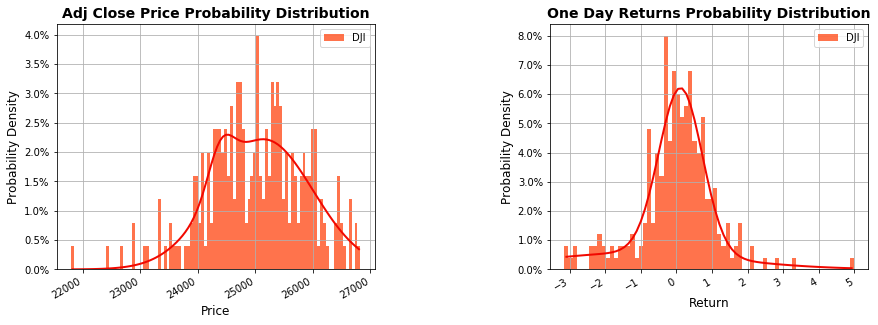

In [116]:
# Initialise subplot.         
fig, axes = subplot_init(1, 2, fig_size = (4, 12))   

# Retrieve price data.
ticker = 'DJI'
price_data = all_stocks[ticker]['Adj Close'].dropna()  

# Plot multimodal price histogram and PDF.
hist_plot_multimodal(axes[0], price_data.to_numpy(), dji_expected, bins = 100,
                     color1 = CMAP_OBJ(0.85), color2 = CMAP_OBJ(0.9), label = ticker)

nice_formatter(axes[0], 'Price', 'Probability Density', 'Adj Close Price Probability Distribution')

# Retrieve returns data.
returns_data = 100 * all_stocks[ticker]['Returns'].dropna()

# Plot multimodal returns histogram and PDF.
hist_plot_multimodal(axes[1], returns_data.to_numpy(), dji_return_expected, bins = 70,
                 color1 = CMAP_OBJ(0.85), color2 = CMAP_OBJ(0.9), label = ticker)

nice_formatter(axes[1], 'Return', 'Probability Density', 'One Day Returns Probability Distribution')


# Save figure.
savefig(fig, section + 'price_rets_dji' + file_fmt)

### 4.1.3 Mean and median estimators analysis

In [117]:
# Create adj close dataframe and populate it.
adj_close_data = pd.DataFrame(columns = tickers)
for ticker in tickers:
    adj_close_data[ticker] = all_stocks[ticker]['Adj Close'].copy()

# Create outliers dataframe. 
outliers = pd.DataFrame(columns = ['Mean - STD', 'Median - MAD', 'Mean - STD With Outliers',
                                   'Median - MAD With Outliers'], index = tickers)

In [118]:
# Define window size.
w = 5 

In [119]:
def mad_c1(data):
    '''
        Function that defines a Median Absolute Deviation with c = 1.
    '''
    return mad_c(data, c=1)

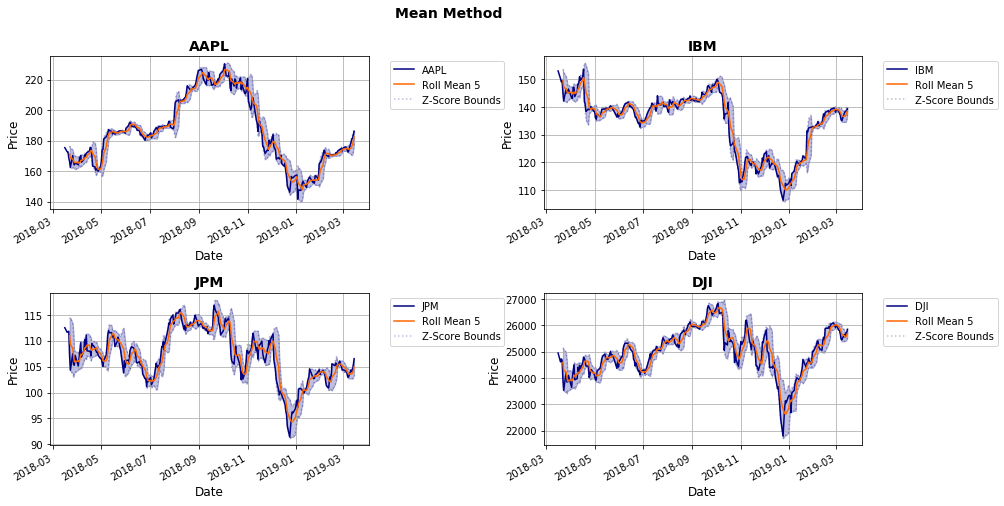

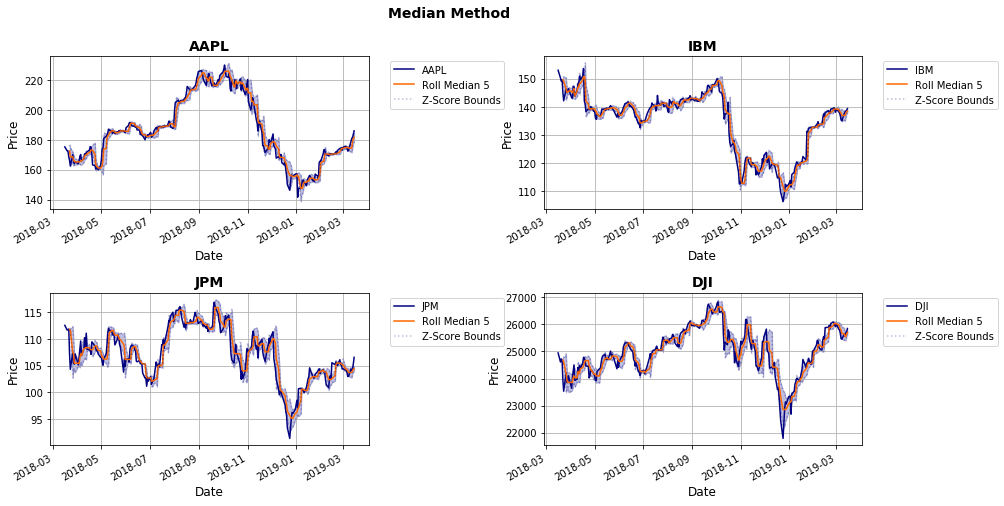

In [120]:
# Initialise subplots.
fig, axes = subplot_init(2, 2, fig_size = (6, 12))
fig.suptitle("Mean Method", **fmt_title, y=1.08)

fig2, axes2 = subplot_init(2, 2, fig_size = (6, 12))
fig2.suptitle("Median Method", **fmt_title, y=1.08)


idx = 0

# For each tickers plot mean and median method analysis.
for ticker in tickers:
    
    # Read ticker data.
    ticker_data = adj_close_data[ticker].copy()
    
    # Compute statistics.
    ticker_roll_mean = ticker_data.rolling(w).mean()
    ticker_roll_median = ticker_data.rolling(w).median()
    upper_bound_mean = ticker_roll_mean + 1.5 * ticker_data.rolling(w).std()
    lower_bound_mean = ticker_roll_mean - 1.5 * ticker_data.rolling(w).std()
    upper_bound_median = ticker_roll_median + 1.5 *  \
                            ticker_data.rolling(w).apply(mad_c1, raw = True)
    lower_bound_median = ticker_roll_median - 1.5  * \
                            ticker_data.rolling(w).apply(mad_c1, raw = True)
    
    # Define axes and legends.
    ax = axes[int(idx > 1)][int(idx % 2)]
    ax2 = axes2[int(idx > 1)][int(idx % 2)]
    
    legend = [ticker, 'Roll Mean 5', 'Z-Score Bounds']
    legend2 = [ticker, 'Roll Median 5', 'Z-Score Bounds']
    
    # Plot z-score bound plots.
    bound_plot(ax, ticker_data, ticker_roll_mean, upper_bound_mean, lower_bound_mean, 
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend)
    
    bound_plot(ax2, ticker_data, ticker_roll_median, upper_bound_median, lower_bound_median, 
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend2)


    # Record outliers count.
    outliers.loc[ticker]['Mean - STD'] = len(ticker_data[ticker_data > upper_bound_mean]) \
                                            + len(ticker_data[ticker_data < lower_bound_mean])
        
    outliers.loc[ticker]['Median - MAD'] = len(ticker_data[ticker_data > upper_bound_median]) \
                                            + len(ticker_data[ticker_data < lower_bound_median])
    idx += 1

    
# Save figures.
savefig(fig, section + 'mean_score' + file_fmt)
savefig(fig2, section + 'median_score' + file_fmt)

### 4.1.4 Estimators' robustness against outliers

In [121]:
# Define dates to be artificiall modified.
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

In [122]:
# Define window size.
w = 5 

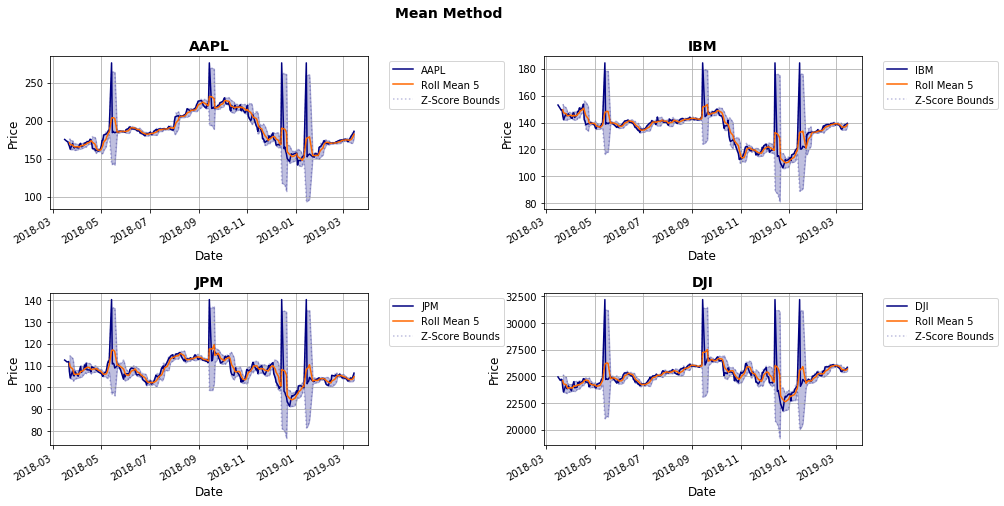

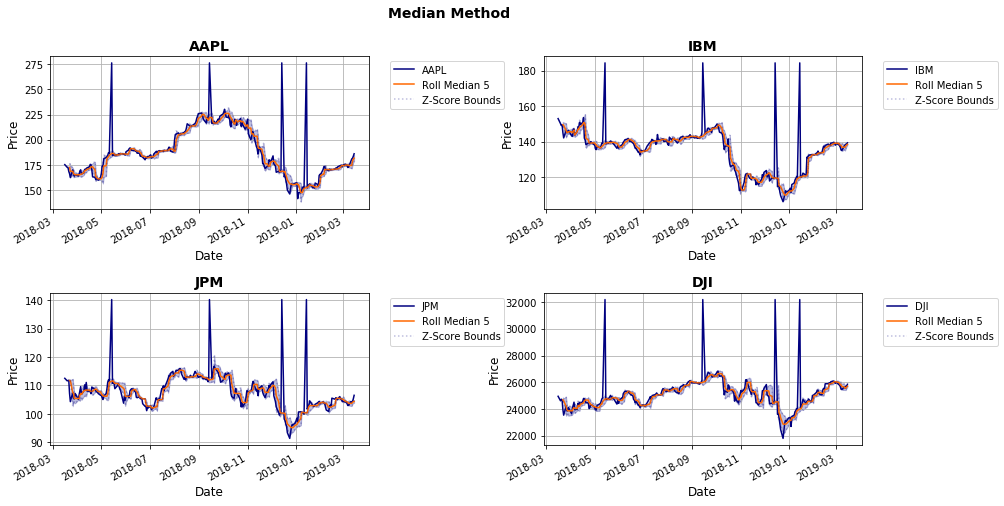

In [123]:
# Initialise subplots.
fig, axes = subplot_init(2, 2, fig_size = (6, 12))
fig.suptitle("Mean Method", **fmt_title, y=1.08)

fig2, axes2 = subplot_init(2, 2, fig_size = (6, 12))
fig2.suptitle("Median Method", **fmt_title, y=1.08)

idx = 0

# For each tickers plot mean and median method analysis.
for ticker in tickers:
    
    # Read data.
    max_price = adj_close_data[ticker].max()
    ticker_data = adj_close_data[ticker].copy()
    
    # Artificially place outliers.
    for date in dates:
        ticker_data[date] = 1.2 * max_price
        
    # Compute statistics.
    ticker_roll_mean = ticker_data.rolling(w).mean()
    ticker_roll_median = ticker_data.rolling(w).median()
    upper_bound_mean = ticker_roll_mean + 1.5 * ticker_data.rolling(w).std()
    lower_bound_mean = ticker_roll_mean - 1.5 * ticker_data.rolling(w).std()
    upper_bound_median = ticker_roll_median + 1.5 *  \
                            ticker_data.rolling(w).apply(mad_c1, raw = True)
    lower_bound_median = ticker_roll_median - 1.5  * \
                            ticker_data.rolling(w).apply(mad_c1, raw = True)
    
    # Define axes and legends.
    ax = axes[int(idx > 1)][int(idx % 2)]
    ax2 = axes2[int(idx > 1)][int(idx % 2)]
    
    legend = [ticker, 'Roll Mean 5', 'Z-Score Bounds']
    legend2 = [ticker, 'Roll Median 5', 'Z-Score Bounds']

    # Record outliers count.
    outliers.loc[ticker]['Mean - STD With Outliers'] = len(ticker_data[ticker_data > upper_bound_mean]) \
                                                        + len(ticker_data[ticker_data < lower_bound_mean])
        
    outliers.loc[ticker]['Median - MAD With Outliers'] = len(ticker_data[ticker_data > upper_bound_median]) \
                                                          + len(ticker_data[ticker_data < lower_bound_median])
    # Plot z-score bound plots.
    bound_plot(ax, ticker_data, ticker_roll_mean, upper_bound_mean, lower_bound_mean, 
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend)
    
    bound_plot(ax2, ticker_data, ticker_roll_median, upper_bound_median, lower_bound_median, 
               xlabel = 'Date', ylabel = 'Price', title = ticker, legend = legend2)
    
    idx += 1

    
# Save figures.
savefig(fig, section + 'mean_out_score' + file_fmt)
savefig(fig2, section + 'median_out_score' + file_fmt)

In [124]:
display(outliers)

Mean - STD Median - MAD Mean - STD With Outliers  \
AAPL         30          103                       32   
IBM          31           94                       31   
JPM          33          105                       33   
DJI          30           97                       29   

     Median - MAD With Outliers  
AAPL                        102  
IBM                          93  
JPM                         101  
DJI                          96

### 4.1.5 Box plot analysis

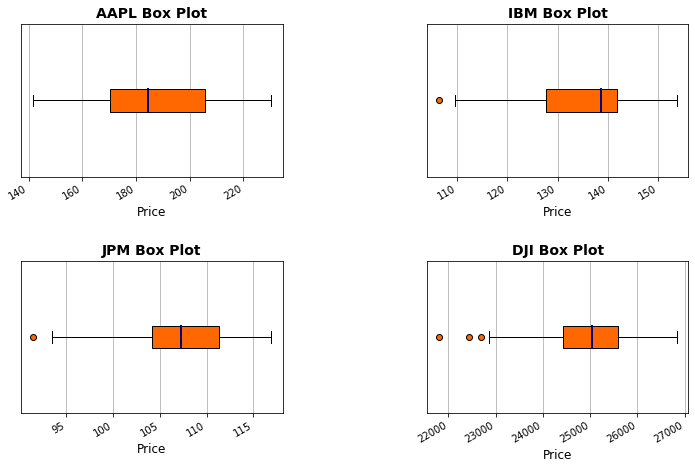

In [125]:
# Initialise variables and subplots.
marker = dict(markerfacecolor = CMAP_OBJ(0.8), marker= 'o')
medianprops = dict(color=CMAP_OBJ(0), linewidth = 2)

fig, axes = subplot_init(2, 2, fig_size = (6, 10)) 
idx = 0

# For each ticker, make box plots.
for ticker in tickers:    
    # Define axis.
    ax = axes[int(idx > 1)][int(idx % 2)]   
    
    # Plot box plots and format.
    bplot = ax.boxplot(adj_close_data[ticker], vert=False, flierprops = marker, 
                       patch_artist=True, medianprops = medianprops)
    bplot['boxes'][0].set_facecolor(CMAP_OBJ(0.8))
     
    ax.set_yticks([])
    ax.grid('on')
    nice_formatter(ax, "Price", "", ticker + " Box Plot", legend_on = False)
    
    idx += 1

    
# Save figure    
savefig(fig, section + 'box_plots' + file_fmt)

## 4.2 Robust Estimators

### 4.2.1 Robust estimators' definition

In [126]:
def my_median(data):
    '''
        Custom function to compute median.
    '''
    # sort data
    data = data.sort_values() 
    # if length of sequence is odd, simply take the middle value.
    # else return the average of the two middle values.
    if len(data) % 2 == 0:
        return data[int(len(data) / 2)]
    else:
        median_low  = data[int(len(data) / 2) - 1] 
        median_high = data[int(len(data) / 2)]
        return (median_low + median_high) / 2  
        
        
def my_iqr(data):
    '''
        Custom function to compute Inter-Quartile range.
    '''
    # sort data
    data = data.sort_values() 
    
    # if length of sequence is odd, simply take the first and third quartiles.
    # else return the average of the two values around the quartiles.
    if len(data) % 2 == 0:
        quart1 = data[int(len(data) / 4)]
        quart3 = data[int(len(data) * 3 / 4)] 
        return quart3 - quart1
    else:
        quart1_low = data[int(len(data) / 4) - 1]
        quart1_high = data[int(len(data) / 4)]
        quart3_low = data[int(len(data) * 3 / 4) - 1] 
        quart3_high = data[int(len(data) * 3 / 4)] 
        
        return (quart3_high + quart3_low) / 2 - (quart1_high + quart1_low) / 2     
    
def my_mad(data):
    '''
        Custom function to compute Median Absolute Deviation.
    '''
    # compute the magnitude of the data deviation from the mean.
    dev = abs(data - my_median(data))
    # return the median of the deviations.
    return my_median(dev) 
   

In [127]:
# Initialise and populate comparison dataframe.
comparison = pd.DataFrame(columns = ['Builtin Median', 'Builtin IQR', 'Builtin Mad', \
                                     'my_median', 'my_iqr', 'my_mad'], index = tickers)

for ticker in tickers:
    data = adj_close_data[ticker].copy()
    comparison.loc[ticker] = [data.median(), iqr(data), mad_c(data, c = 1), \
                              my_median(data), my_iqr(data), my_mad(data)]

In [128]:
display(comparison)

Builtin Median  Builtin IQR Builtin Mad     my_median       my_iqr  \
AAPL     184.351776     35.68544   15.476044    184.287506    35.691315   
IBM      138.566391    14.103938    4.493515    138.563195    14.684692   
JPM      107.219269     7.222442    3.450157    107.207867     7.287441   
DJI    25044.289063  1158.155273  590.720703  25035.679688  1171.695312   

          my_mad  
AAPL   15.331604  
IBM     4.467422  
JPM     3.443718  
DJI   589.875001

### 4.2.2 Complexity of custom estimators 

Sorting the **pandas.Series** is the first step in computing both the median and the inter-quartile range. 
Pandas documentation defines the syntax of the built-in function **Series.sort_values** as shown below:

___Series.sort_values(axis=0, ascending=True, inplace=False, 
                  kind='quicksort', na_position='last')___

Arguments that are equated to a value in the function declaration in Python are parsed so that the value becomes the default of that argument, in case the function call does not explicitly specify otherwise.
Therefore the merging used in the custom function applies the "quicksort" algorithm, that has complexity $O(n\cdot \log(n))$, where $n$ is the length of the **pandas.Series**.
Then, the operations of complexity $O(1)$ are: the arithmetic and modulus operations, the logic comparison with zero, the accesses to a series element through the subscript operator, the calls to built-in functions such as \texttt{len} and the dynamic castings  **int**. This total of seven operations (including modulus), one logic comparison, three indexing operations, three **len** function calls and three dynamic casting operations have complexity $17 \cdot O(1)$ and can be neglected in the overall complexity computation.
A similar analysis can be carried on the function **my_iqr**. The sorting operation has complexity of   $O(n\cdot \log(n))$ as before, while the number of $O(1)$ operations performed doubles (total of 34). 
Finally the MAD computation applies the **abs** built-in function to take the absolute value of the deviations, which are computed by subtracting the data from the median, which is calculated using the custom **my_median** function that is $O(n\cdot \log(n))$ complex. The **abs** and subtraction operations have complexity $O(1)$ as before, but they are now applied leveraging Python's vectorisation capabilities to each element of the input **pandas.Series**. Therefore, applying the two operations to the whole series has complexity $n \cdot O(1) = O(n)$.
Finally, the function **my_median** is called again on the input sequence **dev**, which has been defined as the series of deviations and is by definition of the same length of the original data which is $n$. Therefore, the median operation on the deviations has complexity $O(n\cdot \log(n))$.
Studying the overall computational cost of the custom functions discussed in this section it should be mentioned that for reasonably small input sequences the $O(1)$ operations are not neglegible, thus making the median estimator the fastest, closely followed by the IQR, which performs just a few more $O(1)$ operations and finally the MAD.

### 4.2.3 Breakdown points analysis

Breakdown point analysis measures the robustness of an estimator, i.e. the maximum rate of outliers that an estimator
can tolerate. It is defined as a decimal variable in the range $[0, 0.5]$ where high values denote high robustness of the estimators. The upper limit of 0.5 is related to the logical assumption that if more than half of the data constitutes outliers, then the outliers would become the inliers and viceversa.
The median estimator computation is based on the middle value of the sorted series, which means that up to half of the sequences' length minus one can be contaminated without affecting the estimation.
Mathematically, the breakdown point ($BP$) for the Median estimator can be defined as:
\begin{equation}
    BP_{median} = \frac{\left(\frac{n-1}{2}\right)}{n} = \frac{1}{2} - \frac{1}{2n} 
\end{equation}

As the input series length gets larger ($n \to \infty$), the asymptotic breakdown point is:

\begin{equation}
    \lim_{n \to \infty}[BP_{median}] =  \lim_{n \to \infty} \left[\frac{1}{2} - \frac{1}{2n}\right] = \frac{1}{2}
\end{equation}

Hence the median has the highest possible robustness against outliers, with a breakdown point of 0.5.
The IQR instead takes into account the values of the first and third quartile. This is equivalent to splitting the sorted data into two sequences of equal length and considering the median of each sequence. 
Therefore the breakdown point of IQR is half the one of the median, so 0.25. Finally, the MAD takes into account the median of the data to calculate the deviations and then the median of the absolute deviations. Therefore, the breakdown point will be the same as the median, which is 0.5.

## 4.3 Huber and OLS Regression

In [129]:
# Path to save figures.
section = 'img/sec4/4.3/'

### 4.3.1 Ordinary least squares (OLS) regression

In [130]:
# retrieve returns data.
returns = pd.DataFrame(columns = tickers)

for ticker in tickers:
    returns[ticker] = all_stocks[ticker]['Returns'].copy().dropna()
    
# Initialise parameters dataframe.
parameters = pd.DataFrame(columns = tickers, index = ['OLS ' + sub[':alpha'], 'OLS ' + sub[':beta'], \
                                                      'Huber ' + sub[':alpha'], 'Huber ' + sub[':beta']])

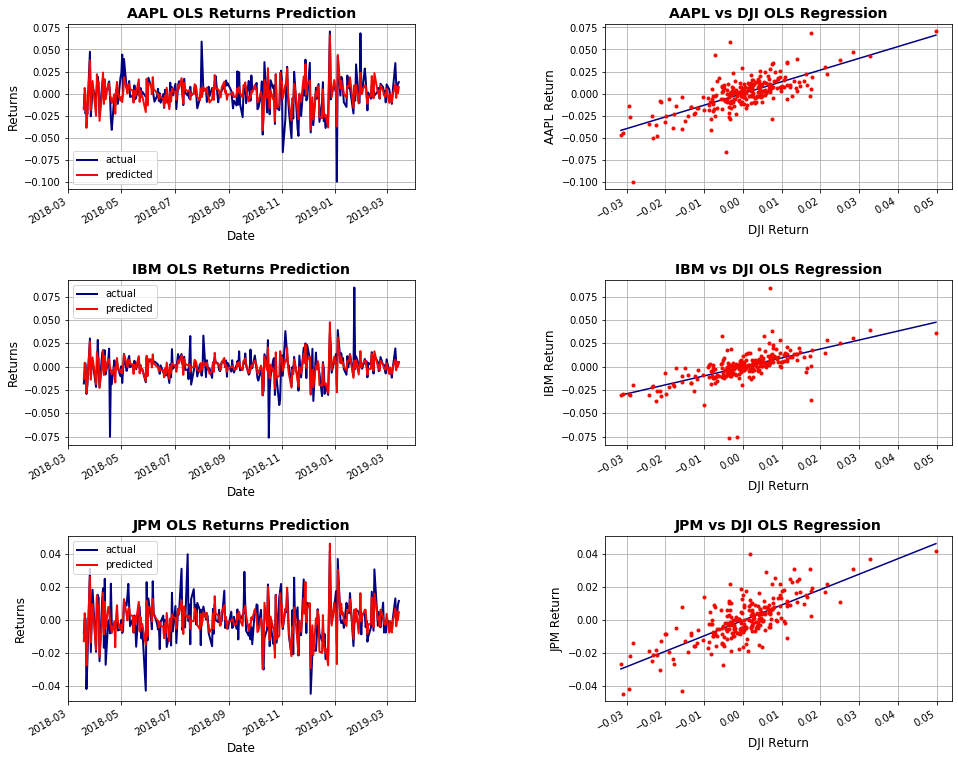

In [131]:
# Define regression model and other variables.
regression_model = linear_model.LinearRegression()
x = returns['DJI'].copy().values.reshape(-1,1)
linspace_x = np.linspace(x.min(), x.max())
color1 = CMAP_OBJ(0)
color2 = CMAP_OBJ(0.9)
idx = 0

# Initialise subplot.
fig, axes = subplot_init(3, 2, fig_size = (10, 13)) 

# Plot predictions and regression fit for each stock ticker.
for ticker in tickers:
    # Get stock return data.
    y = returns[ticker].copy().values.reshape(-1, 1)
    
    # Fit regression model
    regression_model.fit(x, y)
    
    # Log parameters.
    parameters[ticker]['OLS ' +  sub[':alpha']] = float(regression_model.intercept_)
    parameters[ticker]['OLS ' +  sub[':beta']] = float(regression_model.coef_)
    
    if ticker != 'DJI':
        # Define axes.
        ax0 = axes[idx][0]
        ax1 = axes[idx][1]
        
        # Compute predictions.
        predictions = regression_model.predict(x)
        
        # Plot returns actual vs predicted.
        pretty_plot(ax0, returns[ticker].index, var2 = y, label = 'actual')
        pretty_plot(ax0, returns[ticker].index, var2 = predictions, label = 'predicted', color = color2)
        nice_formatter(ax0, 'Date', 'Returns', ticker + ' OLS Returns Prediction')
    
        # Fit model and retrieve coefficients.
        model = regression_model.fit(x, y.ravel())
        coef = model.coef_ * linspace_x + model.intercept_
        
        # Plot regression fit.
        ax1.plot(linspace_x, coef, color = color1)
        ax1.plot(x, y, '.', color = color2)
        nice_formatter(ax1, 'DJI Return', ticker + ' Return', 
                       ticker + ' vs DJI OLS Regression', legend_on = False)
        idx += 1
        
# Save figure.
savefig(fig, section + 'OLS' + file_fmt)

### 4.3.2 Huber (robust) regression

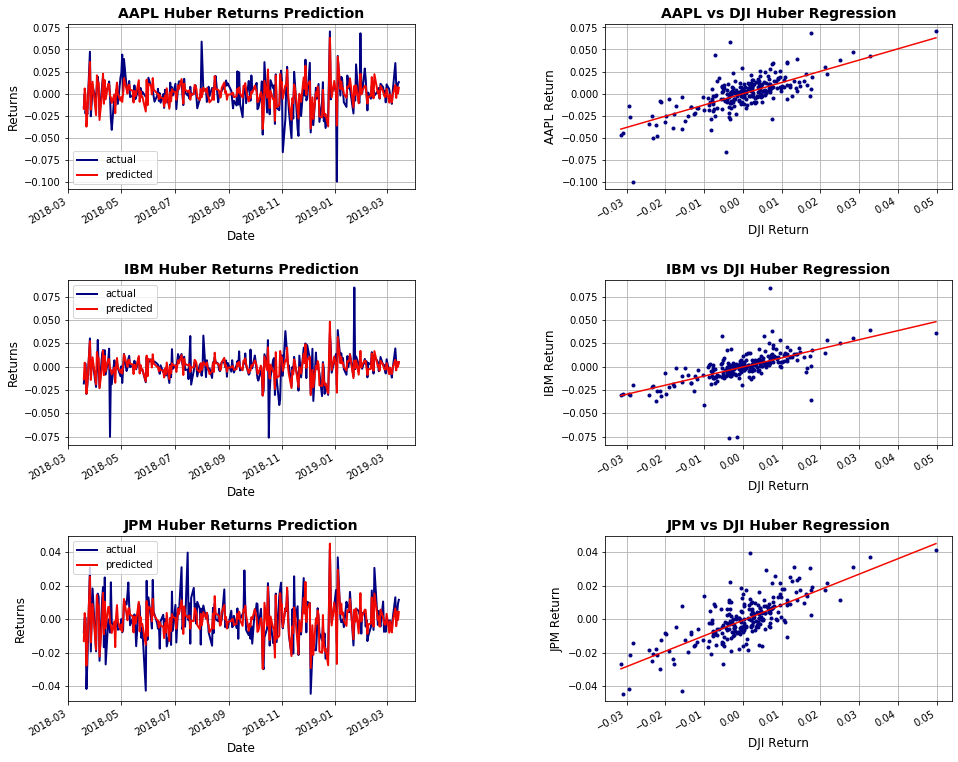

In [132]:
# Define regression model and other variables.
regression_model = linear_model.HuberRegressor()
x = returns['DJI'].copy().values.reshape(-1,1)
linspace_x = np.linspace(x.min(), x.max())

color1 = CMAP_OBJ(0)
color2 = CMAP_OBJ(0.9)
idx = 0

# Initialise subplot.
fig, axes = subplot_init(3, 2, fig_size = (10, 13)) 

# Plot predictions and regression fit for each stock ticker.
for ticker in tickers:
    # Get stock return data.
    y = returns[ticker].copy().values.reshape(-1 )
 
    # Fit regression model
    regression_model.fit(x, y)
    
    # Log parameters.
    parameters[ticker]['Huber ' + sub[':alpha']] = float(regression_model.intercept_)
    parameters[ticker]['Huber ' + sub[':beta']] = float(regression_model.coef_)
    
    if ticker != 'DJI':
        # Define axes.
        ax0 = axes[idx][0]
        ax1 = axes[idx][1]
        
        # Compute predictions.
        predictions = regression_model.predict(x)
        
        # Plot returns actual vs predicted.
        pretty_plot(ax0, returns[ticker].index, var2 = y, label = 'actual')
        pretty_plot(ax0, returns[ticker].index, var2 = predictions, label = 'predicted', color = color2)
        nice_formatter(ax0, 'Date', 'Returns', ticker + ' Huber Returns Prediction')
    
        # Fit model and retrieve coefficients.
        model = regression_model.fit(x, y.ravel())
        coef = model.coef_ * linspace_x + model.intercept_

        # Plot regression fit.
        ax1.plot(x, y, '.', color = color1)
        ax1.plot(linspace_x, coef, color = color2)

        nice_formatter(ax1, 'DJI Return', ticker + ' Return', 
                       ticker + ' vs DJI Huber Regression', legend_on = False)
        idx += 1

# Save figure.
savefig(fig, section + 'Huber' + file_fmt)    

In [133]:
display(parameters)

AAPL       IBM       JPM  DJI
OLS α    0.000165 -0.000441 -0.000316 -0.0
OLS β     1.32558  0.960092  0.931408  1.0
Huber α  -0.00013 -0.000509 -0.000801  0.0
Huber β  1.270212  0.973562  0.919662  1.0

### 4.3.3. Robustness of regression methods against outliers 


In [134]:
# Define dates to artificially make outliers.
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']

In [135]:
# Build prices time series.
for ticker in tickers:
    max_price = returns[ticker].max()
    for date in dates:
        returns[ticker][date] = 1.2 * max_price

# Define outliers parameters dataframe.
outliers_parameters = pd.DataFrame(columns = tickers, index = 
                        ['OLS with Outliers ' + sub[':alpha'], 'OLS with Outliers ' + sub[':beta'], \
                         'Huber with Outliers ' + sub[':alpha'], 'Huber with Outliers ' + sub[':beta']])

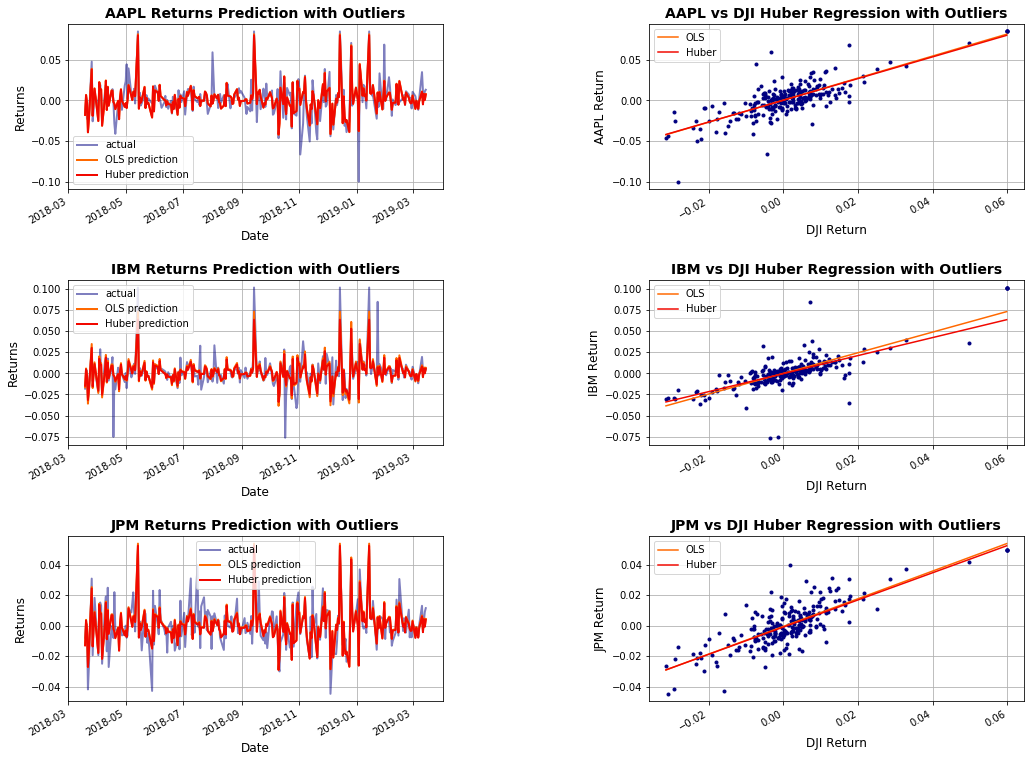

In [136]:
# Define models and variables.
regression_model = linear_model.LinearRegression()
huber_model = linear_model.HuberRegressor()
x = returns['DJI'].copy().values.reshape(-1,1)
linspace_x = np.linspace(x.min(), x.max())

colors = [CMAP_OBJ(0.8), CMAP_OBJ(0.9)]
models = ['OLS', 'Huber']

# Initialise subplot.
fig, axes = subplot_init(3, 2, fig_size = (10, 14)) 

idx = 0
for ticker in tickers:    
    # Get data.
    x = returns['DJI'].copy().values.reshape(-1,1)
    y = returns[ticker].copy().values.reshape(-1,1)
    huber_y = returns[ticker].copy().values.reshape(-1)
    
    # Fit models.
    regression_model.fit(x, y)
    huber_model.fit(x, huber_y)
    
    # Log outliers count.
    outliers_parameters[ticker]['OLS with Outliers ' +  sub[':alpha']] = float(regression_model.intercept_)
    outliers_parameters[ticker]['OLS with Outliers ' +  sub[':beta']] = float(regression_model.coef_)
    outliers_parameters[ticker]['Huber with Outliers ' +  sub[':alpha']] = float(huber_model.intercept_)
    outliers_parameters[ticker]['Huber with Outliers ' +  sub[':beta']] = float(huber_model.coef_)
    
    if ticker != 'DJI':
        # Define axes.
        ax0 = axes[idx][0]
        ax1 = axes[idx][1]
        
        # Plot predictions.
        pretty_plot(ax0, returns[ticker].index, var2 = y, label = 'actual', alpha = 0.5)
        ax1.plot(x, y, '.', color = CMAP_OBJ(0))
        
        m = 0
        # For both methods.
        for model in (regression_model, huber_model):
            
            # Compute predictions
            predictions = model.predict(x)
            
            # Plot returns prediction.
            pretty_plot(ax0, returns[ticker].index, var2 = predictions, 
                        label = models[m] + ' prediction', color = colors[m])
            
            # Fit model and compute coefficients.
            mod = model.fit(x, y.ravel())
            coef = mod.coef_ * linspace_x + mod.intercept_

            # Plot regression.
            ax1.plot(linspace_x, coef, color = colors[m], label = models[m])
            
            m += 1
            
        # Format axes.
        nice_formatter(ax0, 'Date', 'Returns', ticker + ' Returns Prediction with Outliers')
        nice_formatter(ax1, 'DJI Return', ticker + ' Return', 
                           ticker + ' vs DJI Huber Regression with Outliers') 
        idx += 1

# Save figure.
savefig(fig, section + 'regr_with_outliers' + file_fmt)    

In [137]:
outliers_parameters

AAPL       IBM       JPM  DJI
OLS with Outliers α     0.00035 -0.000063 -0.000467  0.0
OLS with Outliers β    1.350465   1.22204  0.906468  1.0
Huber with Outliers α  0.000122 -0.000339 -0.000933  0.0
Huber with Outliers β  1.330773  1.066643  0.890359  1.0

## 4.4 Robust Trading Strategies

In [138]:
# Define path for figures.
section = 'img/sec4/4.4/'

### 4.4.1 Moving average crossover

In [139]:
# read adj close data.
adj_close_data = pd.DataFrame(columns = tickers)
for ticker in tickers:
    adj_close_data[ticker] = all_stocks[ticker]['Adj Close'].copy()

# Seed for reproducibility.
np.random.seed(0)
    
# modify adj close data to add outliers.
adj_close_data_rand_outliers = pd.DataFrame(columns = tickers)
for ticker in tickers:
    data = adj_close_data[ticker].copy()
    delta = data.max() - data.mean()
    
    for idx in range(0, 250, 25):
        data[idx] += float([-2,2][np.random.randint(0, 2)] * delta)
    adj_close_data_rand_outliers[ticker] = data

In [140]:
# Similarity between strategies log.
strategy_simil = pd.DataFrame(columns = ['MA Strategy Similarity w/out Outliers', 
                                         'MM Strategy Similarity w/out Outliers'], index = tickers
                              )

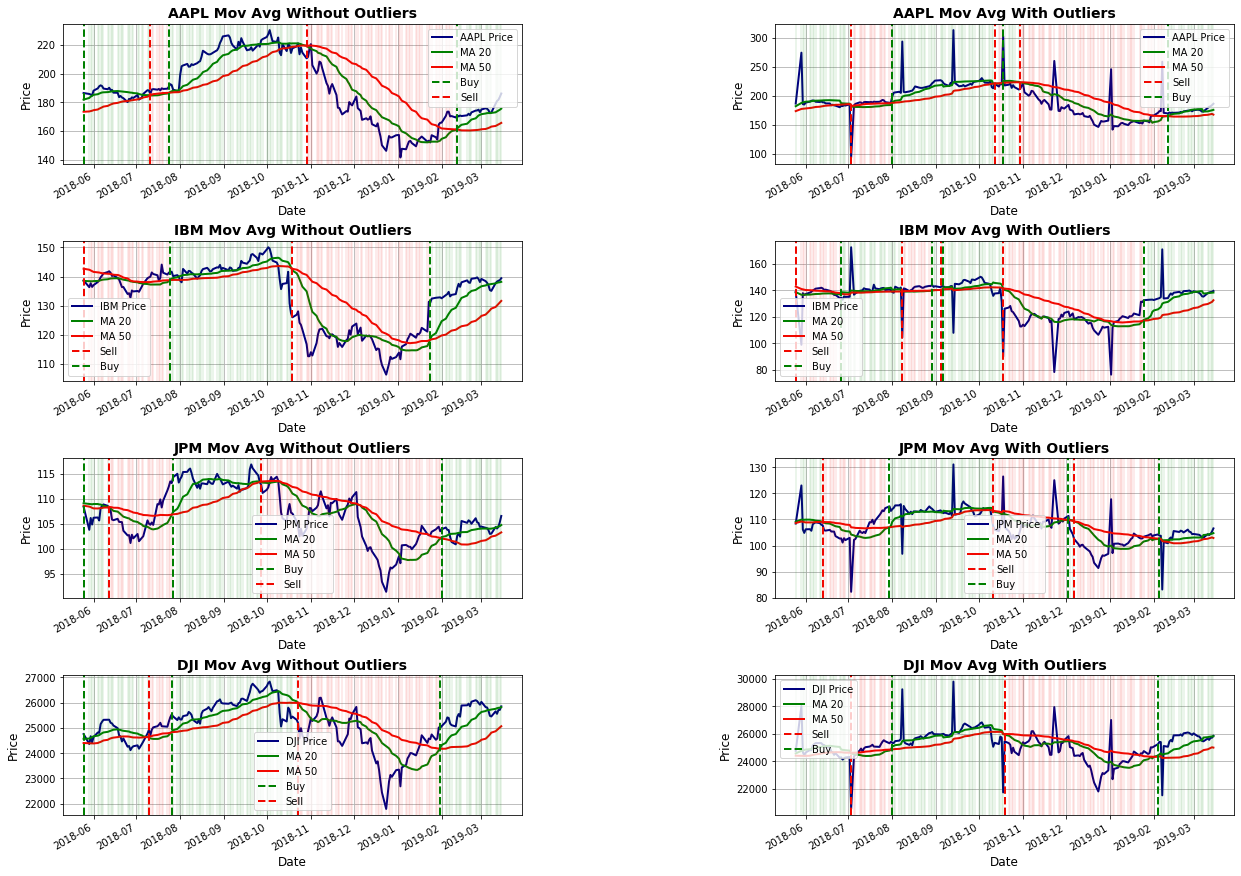

In [141]:
# Initialise subplot.
fig, axes = subplot_init(4, 2, fig_size = (14, 17))

row = 0
for ticker in tickers:
    
    # Initialise variables.
    ma_buy_decisions = []
    outliers_ma_buy_decisions = []
    col = 0
    previous_decision = 0
    
    # For both data with/out outliers.
    for adj_data in [adj_close_data, adj_close_data_rand_outliers]:
        
        # Get ax and data.
        ax = axes[row][col]
        data = adj_data[ticker].dropna()

        # Compute statistics.
        ma_20 = data.rolling(20).mean()
        ma_50 = data.rolling(50).mean()
        ma_buy = np.sign((ma_20 - ma_50).dropna())
        
        # Define title.
        if col == 0:
            title = ticker + " Mov Avg Without Outliers"
        else:
            title = ticker + " Mov Avg With Outliers"
        
        start_idx = ma_buy.index[0] 

        # Plot the three curvers (data, mov-avg 20 and 50).
        pretty_plot(ax, data[start_idx:], label = ticker + " Price")
        pretty_plot(ax, ma_20[start_idx:], color = 'g', label = "MA 20")
        pretty_plot(ax, ma_50[start_idx:], color = CMAP_OBJ(0.9), label = "MA 50")

        
        # Plot green and red zones.
        buy_label = 'Buy'
        sell_label = 'Sell'
        for buy_idx in ma_buy.index:
            
            # Plot buying decision day by day as vertical green or red lines.
            current_decision = ma_buy[buy_idx]
            
            ## Green lines - BUY.
            if  current_decision == 1:
                if previous_decision != current_decision:
                        ax.axvline(x = buy_idx, alpha = 1, color = 'g',
                                   linewidth = 2, linestyle = '--', label = buy_label)
                        buy_label = ''
                else :
                    ax.axvline(x = buy_idx, alpha = 0.1, color = 'g')
            
            ## Red lines - SELL.
            if ma_buy[buy_idx] == -1:
                if previous_decision != current_decision:
                    ax.axvline(x = buy_idx, alpha = 1, color = CMAP_OBJ(0.9),
                               linewidth = 2, linestyle = '--', label = sell_label)
                    sell_label = ''
                else:
                    ax.axvline(x = buy_idx, alpha = 0.1, color = CMAP_OBJ(0.9)) 
            previous_decision = current_decision
        
        # Initial line.
        if col == 0:
            ma_buy_decisions = ma_buy
        else:
            outliers_ma_buy_decisions = ma_buy
        
        # Format axis.
        nice_formatter(ax, "Date", "Price", title)
        col += 1

    # Log strategy difference.
    strategy_simil.loc[ticker]['MA Strategy Similarity w/out Outliers'] = \
         len(outliers_ma_buy_decisions[outliers_ma_buy_decisions == ma_buy_decisions]) / \
         len(ma_buy_decisions) * 100
    row += 1

# Save figure.    
savefig(fig, section + 'mov_avg_analysis' + file_fmt)    

### 4.4.2. Moving median crossover

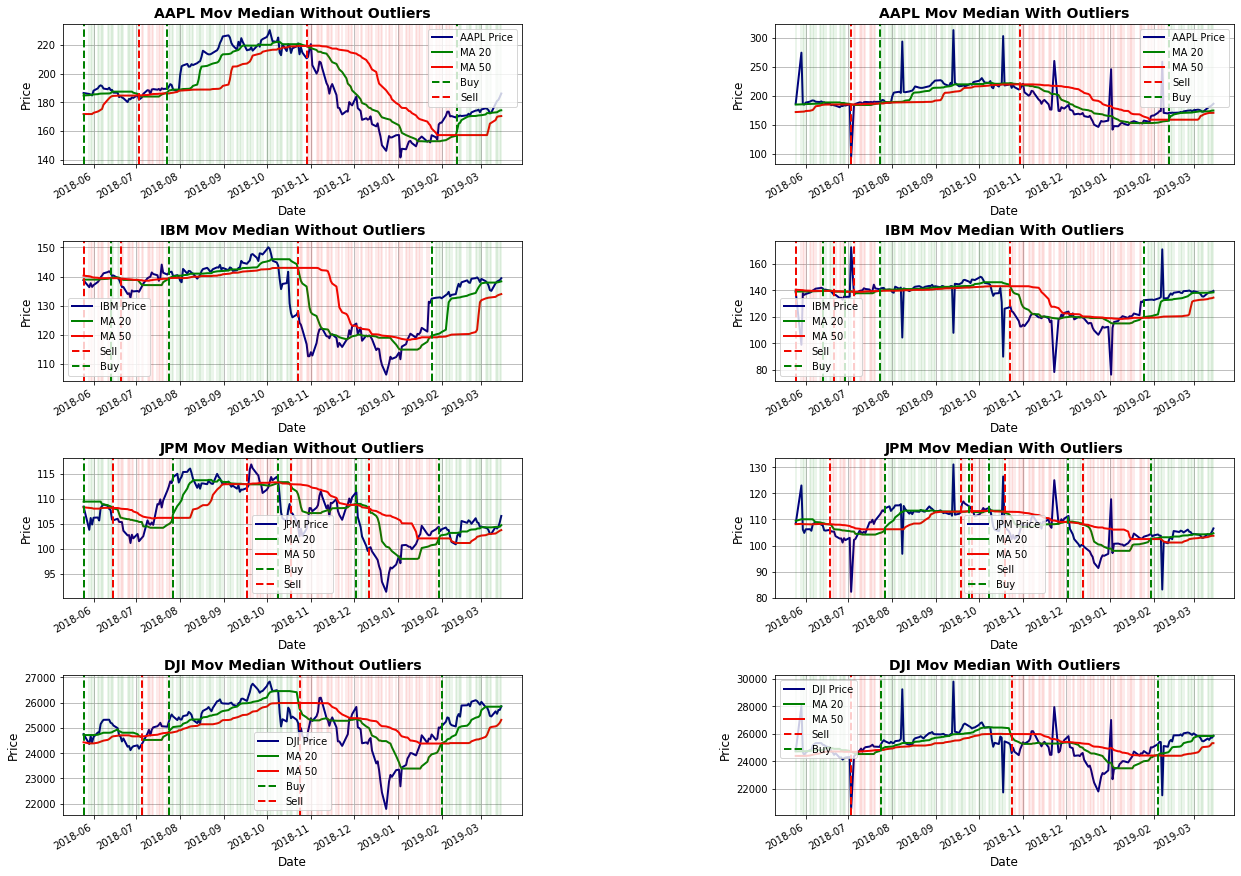

In [142]:
# Initialise subplot.
fig, axes = subplot_init(4, 2, fig_size = (14, 17))

row = 0
for ticker in tickers:
    
    # Initialise variables.
    mm_buy_decisions = []
    outliers_mm_buy_decisions = []
    col = 0
    previous_decision = 0

    # For both data with/out outliers.
    for adj_data in [adj_close_data, adj_close_data_rand_outliers]:
        
        # Get ax and data.
        ax = axes[row][col]
        data = adj_data[ticker].dropna()

        # Compute statistics.
        mm_20 = data.rolling(20).median()
        mm_50 = data.rolling(50).median()
        mm_buy = np.sign((mm_20 - mm_50).dropna())
        
        # Define title.
        if col == 0:
            title = ticker + " Mov Median Without Outliers"
        else:
            title = ticker + " Mov Median With Outliers"
        
        start_idx = mm_buy.index[0] 

        # Plot the three curvers (data, mov-avg 20 and 50).
        pretty_plot(ax, data[start_idx:], label = ticker + " Price")
        pretty_plot(ax, mm_20[start_idx:], color = 'g', label = "MA 20")
        pretty_plot(ax, mm_50[start_idx:], color = CMAP_OBJ(0.9), label = "MA 50")

        # Plot green and red zones.
        buy_label = 'Buy'
        sell_label = 'Sell'
        for buy_idx in mm_buy.index:
            # Plot buying decision day by day as vertical green or red lines.
            
            current_decision = mm_buy[buy_idx]
            
            ## Green lines - BUY.
            if  current_decision == 1:
                if previous_decision != current_decision:
                        ax.axvline(x = buy_idx, alpha = 1, color = 'g',
                                   linewidth = 2, linestyle = '--', label = buy_label)
                        buy_label = ''
                else :
                    ax.axvline(x = buy_idx, alpha = 0.1, color = 'g')
            
            ## Red lines - SELL.
            if mm_buy[buy_idx] == -1:
                if previous_decision != current_decision:
                    ax.axvline(x = buy_idx, alpha = 1, color = CMAP_OBJ(0.9),
                               linewidth = 2, linestyle = '--', label = sell_label)
                    sell_label = ''
                else:
                    ax.axvline(x = buy_idx, alpha = 0.1, color = CMAP_OBJ(0.9)) 
            previous_decision = current_decision
        
        # Initial line.
        if col == 0:
            mm_buy_decisions = mm_buy
        else:
            outliers_mm_buy_decisions = mm_buy
        
        # Format axis.
        nice_formatter(ax, "Date", "Price", title)
        col += 1
      
    # Log strategy difference.
    strategy_simil.loc[ticker]['MM Strategy Similarity w/out Outliers'] = \
         len(outliers_mm_buy_decisions[outliers_mm_buy_decisions == mm_buy_decisions]) / \
         len(mm_buy_decisions) * 100
    row += 1

# Save figure.    
savefig(fig, section + 'mov_median_analysis' + file_fmt)    

In [143]:
display(strategy_simil)

MA Strategy Similarity w/out Outliers  \
AAPL                             91.584158   
IBM                              80.693069   
JPM                              91.584158   
DJI                              94.059406   

     MM Strategy Similarity w/out Outliers  
AAPL                              99.50495  
IBM                              97.524752  
JPM                              96.039604  
DJI                              99.009901

# 5 Graph in Finance

## 5.1 S&P stocks subset

In [144]:
# Load data of stocks.
all_stocks = pd.read_csv(data_folder + 'snp_allstocks_2015_2019.csv', header = 0, index_col = 0)
snp_info = pd.read_csv(data_folder + 'snp_info.csv', index_col = 0)

# Define locations.
locations = ['Santa Clara, California', 'San Jose, California']

In [145]:
# Filter only the Tech Companies.
chosen_market = snp_info.copy().set_index('Symbol')
chosen_market = chosen_market.loc[chosen_market['GICS Sector'] == 'Information Technology']

# There are 11 companies based in the area of San Jose / Santa Clara.
chosen_stocks = [chosen_market['Headquarters Location'][i] in locations for i in chosen_market.index]
chosen_market = chosen_market.loc[chosen_stocks]

# Dropping one Semiconductor Company as it was the most represented Sub Industry to make it 10.
chosen_market = chosen_market.loc[chosen_market['Security'] != 'Broadcom']

chosen_market = chosen_market.sort_values('GICS Sub Industry')

display(chosen_market[['Security', 'GICS Sector', 'GICS Sub Industry', 'Headquarters Location']])

Security             GICS Sector  \
Symbol                                                          
ADBE                Adobe Systems Inc  Information Technology   
CDNS           Cadence Design Systems  Information Technology   
ANET                  Arista Networks  Information Technology   
CSCO                    Cisco Systems  Information Technology   
PYPL                           PayPal  Information Technology   
AMAT           Applied Materials Inc.  Information Technology   
INTC                      Intel Corp.  Information Technology   
MXIM    Maxim Integrated Products Inc  Information Technology   
NVDA               Nvidia Corporation  Information Technology   
XLNX                           Xilinx  Information Technology   

                            GICS Sub Industry    Headquarters Location  
Symbol                                                                  
ADBE                     Application Software     San Jose, California  
CDNS                     Application Software     San Jose, California  
ANET                 Communications Equipment  Santa Clara, California  
CSCO                 Communications Equipment     San Jose, California  
PYPL    Data Processing & Outsourced Services     San Jose, California  
AMAT                  Semiconductor Equipment  Santa Clara, California  
INTC                           Semiconductors  Santa Clara, California  
MXIM                           Semiconductors     San Jose, California  
NVDA                           Semiconductors  Santa Clara, California  
XLNX                           Semiconductors     San Jose, California

In [146]:
# Get log-returns for ten stocks.
stocks = chosen_market.index
returns = np.log(all_stocks[stocks]).diff(1).dropna() 

display(returns)

ADBE      CDNS      ANET      CSCO      PYPL      AMAT  \
Date                                                                     
2015-07-07  0.001117 -0.005692 -0.012075  0.005130 -0.002455 -0.005203   
2015-07-08 -0.007473 -0.002598 -0.030001 -0.013616 -0.053855 -0.032877   
2015-07-09  0.005983  0.011896  0.010271 -0.002968 -0.005780 -0.001618   
2015-07-10  0.001490  0.006662  0.028210  0.013656  0.005492  0.013409   
2015-07-13  0.010492  0.010668 -0.013250  0.018522  0.058503  0.028363   
...              ...       ...       ...       ...       ...       ...   
2018-12-24 -0.017587 -0.009383 -0.022353 -0.038237 -0.013918 -0.044527   
2018-12-26  0.083157  0.055020  0.059696  0.052943  0.071844  0.055355   
2018-12-27  0.009775  0.019070  0.021266  0.010307  0.018072  0.029267   
2018-12-28 -0.008968 -0.001614  0.004530 -0.003268 -0.012532  0.025967   
2018-12-31  0.013842  0.003225  0.023725  0.013008  0.009919  0.011057   

                INTC      MXIM      NVDA      XLNX  
Date                                                
2015-07-07 -0.004671 -0.013257 -0.019020  0.004135  
2015-07-08 -0.013468 -0.026139 -0.007099 -0.022254  
2015-07-09 -0.019511 -0.025279 -0.012289 -0.019170  
2015-07-10  0.008262  0.007465  0.017365  0.002148  
2015-07-13  0.019016 -0.004348  0.006561  0.013735  
...              ...       ...       ...       ...  
2018-12-24 -0.028273 -0.032887 -0.019405 -0.027866  
2018-12-26  0.057936  0.055442  0.046284  0.072376  
2018-12-27  0.003674  0.013093 -0.014607 -0.010854  
2018-12-28  0.008377  0.003197  0.018730  0.000474  
2018-12-31  0.003843  0.014260 -0.001123  0.009793  

[879 rows x 10 columns]

## 5.2 Correlation matrix and network

In [147]:
# Path to save figures.
section = 'img/sec5/5.2/'

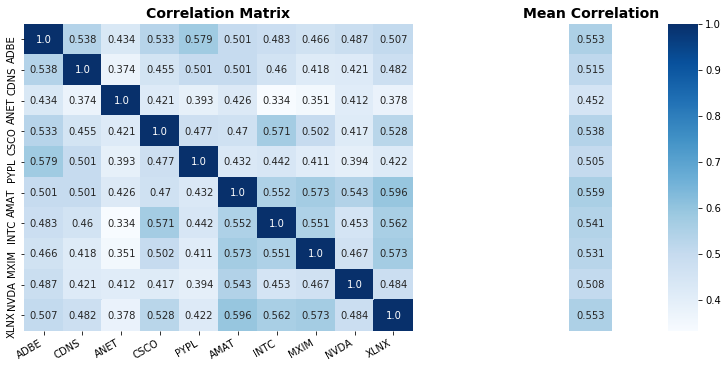

In [148]:
# Calculate correlation matrix
import matplotlib.gridspec as gridspec

# Compute correlation.
corr = returns.corr()

# Plot the heatmap.
fig = plt.figure(constrained_layout=True, figsize = (10, 5))
gs = fig.add_gridspec(1, 8)

# Define axes.
ax0 = fig.add_subplot(gs[0:5])
ax1 = fig.add_subplot(gs[7])

# Plot correlation matrix.
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, 
                cmap = 'Blues', annot=True, fmt='.3', ax = ax0, cbar=False)

# Compute mean.
means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(corr.mean())
means.index.name = ''

# Plot means and format axes.
sns.heatmap(means, xticklabels = '', yticklabels = '', cmap = 'Blues', 
            annot = True, vmax = 1, vmin = min(corr.min()), fmt = '.3', ax = ax1)
nice_formatter(ax0, title = 'Correlation Matrix', grid_on = False, legend_on = False)
nice_formatter(ax1, title = 'Mean Correlation', grid_on = False, legend_on = False)

# Save figure.
savefig(fig, section + 'corr_matrix' + file_fmt)    

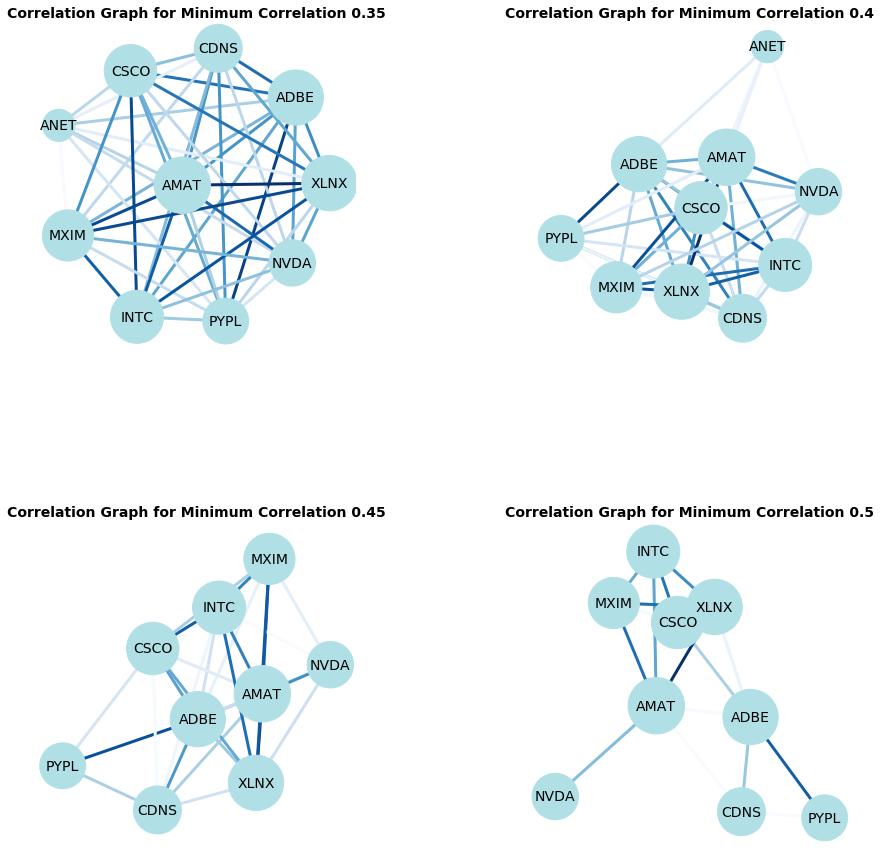

In [149]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Correlations to filter.
corrs = [0.35, 0.40, 0.45, 0.5]

# Initialise subplot
fig, axes = subplot_init(2, 2, fig_size = (12, 12))
idx = 0

# For each correlation.
for c in corrs:
    
    # define axes.
    ax = axes[int(idx > 1)][int(idx % 2)]
    
    # Compute links.
    good_links = links.loc[ abs(links['value'] > c) & (links['var1'] != links['var2']) ]
    
    # Plot the network:
    graph_plotter(good_links, ax = ax, mean_corrs = means)
    nice_formatter(ax, title = 'Correlation Graph for Minimum Correlation ' + str(c), legend_on = False)

    idx += 1

# Save figure.
savefig(fig, section + 'corr_net' + file_fmt)    

## 5.3 Correlation network analysis

In [150]:
# Path for figures.
section = 'img/sec5/5.3/'

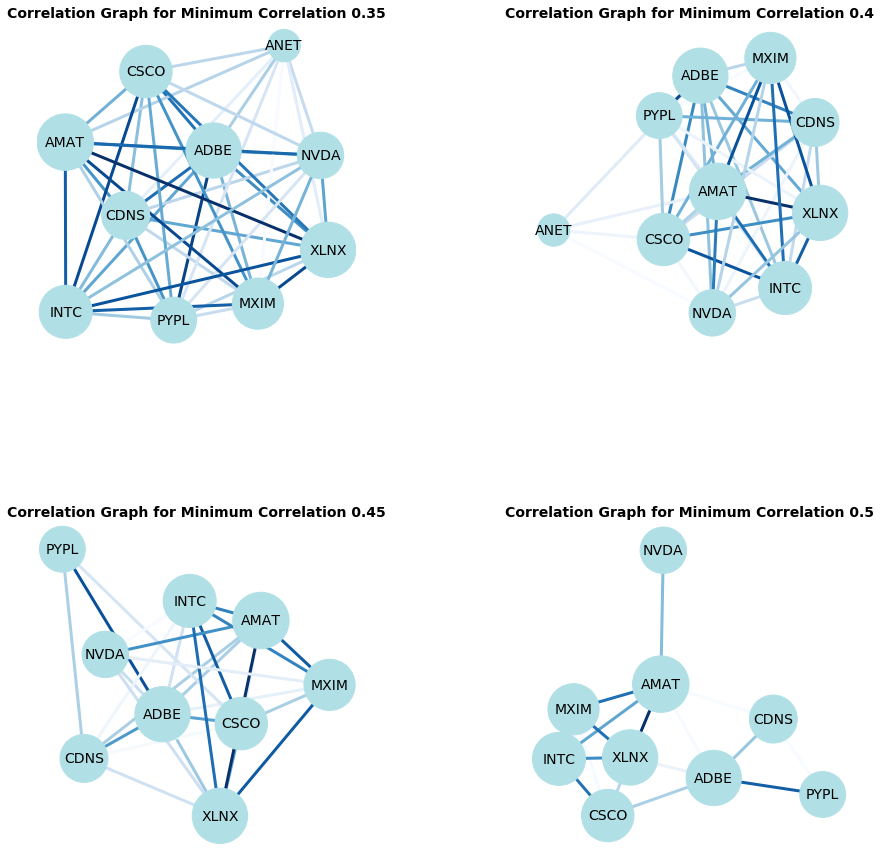

In [151]:
# Calculate correlation matrix.
corr = returns.sample(frac=1, axis=0).corr()

# Transform it in a links data frame (3 columns only).
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Define correlation filters.
corrs = [0.35, 0.40, 0.45, 0.5]

# Initialise subplot.
fig, axes = subplot_init(2, 2, fig_size = (12, 12))
idx = 0

# For each correlation threshold.
for c in corrs:
    # Define axes.
    ax = axes[int(idx > 1)][int(idx % 2)]
    
    # Compute links.
    links_filtered = links.loc[ abs(links['value'] > c) & (links['var1'] != links['var2'])]
    
    # Plot the network.
    graph_plotter(links_filtered, ax = ax, mean_corrs = means)
    nice_formatter(ax, title = 'Correlation Graph for Minimum Correlation ' + str(c), legend_on = False)
    idx += 1

# Save figure.
savefig(fig, section + 'corr_net_reorder' + file_fmt)      

## 5.4 Dynamic time warping distance matrix and network

In [152]:
section = 'img/sec5/5.4/'

In [153]:
# Create the similarity matrix
dtw_matrix = corr

# Go through tickers
for t_idx in returns.columns:
    for t_col in returns.columns:
        distance, path = fastdtw(returns[t_idx], returns[t_col], dist=euclidean)
        dtw_matrix[t_idx][t_col] = distance      

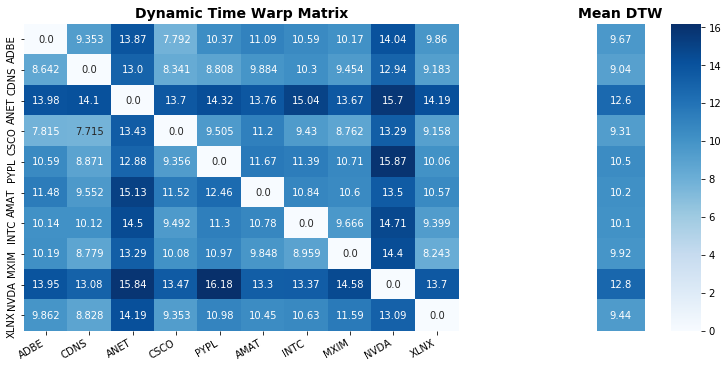

In [154]:
# plot the heatmap
fig = plt.figure(constrained_layout=True, figsize = (10, 5))
gs = fig.add_gridspec(1, 8)

ax0 = fig.add_subplot(gs[0:5])
ax1 = fig.add_subplot(gs[7])

sns.heatmap(dtw_matrix, xticklabels = dtw_matrix.columns, yticklabels = dtw_matrix.columns, 
            cmap = 'Blues', annot=True, fmt='.4', ax = ax0, cbar=False)

means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(dtw_matrix.mean())
means.index.name = ''
sns.heatmap(means, xticklabels = '', yticklabels = '', cmap = 'Blues', annot = True, 
            vmax = max(dtw_matrix.max()), vmin = min(dtw_matrix.min()), fmt = '.3', ax = ax1)

nice_formatter(ax0, title = 'Dynamic Time Warp Matrix', grid_on = False, legend_on = False)
nice_formatter(ax1, title = 'Mean DTW', grid_on = False, legend_on = False)

savefig(fig, section + 'dtw_matrix' + file_fmt)    

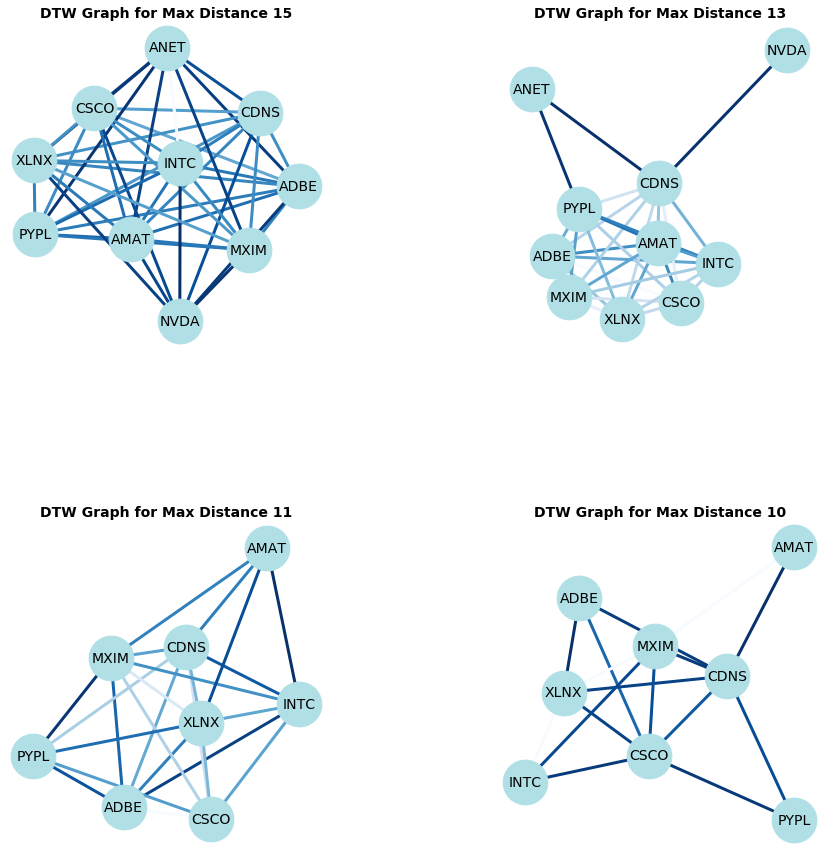

In [155]:
# Transform it in a links data frame (3 columns only):
links = dtw_matrix.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Plot the network:
warps = [15, 13, 11, 10]
fig, axes = subplot_init(2, 2, fig_size = (12, 12))
idx = 0
for w in warps:
    ax = axes[int(idx > 1)][int(idx % 2)]
    links_filtered = links.loc[abs(links['value'] < w) & (links['var1'] != links['var2'])]
    
    # Plot the network reversing distance metric:
    graph_plotter(links_filtered, ax = ax, std = max(dtw_matrix.max()), fact = 10000)
    nice_formatter(ax, title = 'DTW Graph for Max Distance ' + str(w), legend_on = False)
    idx += 1
    
savefig(fig, section + 'dtw_net' + file_fmt)    

#### Repeat Time Series Shuffling

In [156]:
# Shuffle returns
returns = returns.sample(frac=1, axis=0)
corr = returns.corr()

# Create the similarity matrix
dtw_matrix = corr

# Go through tickers
for t_idx in returns.columns:
    for t_col in returns.columns:
        distance, path = fastdtw(returns[t_idx], returns[t_col], dist=euclidean)
        dtw_matrix[t_idx][t_col] = distance 

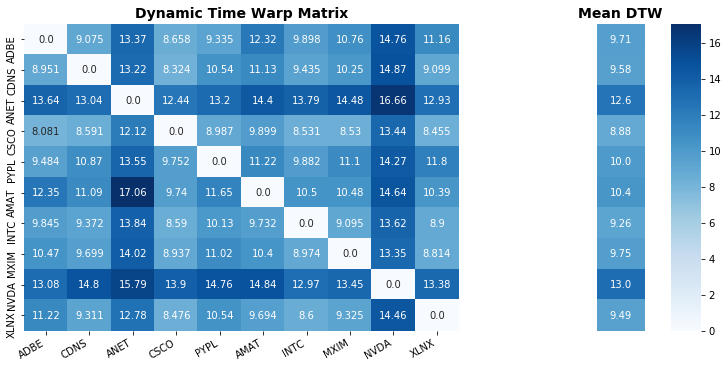

In [157]:
# Plot the heatmap.
fig = plt.figure(constrained_layout=True, figsize = (10, 5))
gs = fig.add_gridspec(1, 8)

# Define axes.
ax0 = fig.add_subplot(gs[0:5])
ax1 = fig.add_subplot(gs[7])

# Plot dtw matrix.
sns.heatmap(dtw_matrix, xticklabels = dtw_matrix.columns, yticklabels = dtw_matrix.columns, 
            cmap = 'Blues', annot=True, fmt='.4', ax = ax0, cbar=False)

# Compute means.
means = pd.DataFrame(index = stocks)
means.loc[:, -1] = np.array(dtw_matrix.mean())
means.index.name = ''

# Plot dtw means.
sns.heatmap(means, xticklabels = '', yticklabels = '', cmap = 'Blues', annot = True, 
            vmax = max(dtw_matrix.max()), vmin = min(dtw_matrix.min()), fmt = '.3', ax = ax1)

# Format axes.
nice_formatter(ax0, title = 'Dynamic Time Warp Matrix', grid_on = False, legend_on = False)
nice_formatter(ax1, title = 'Mean DTW', grid_on = False, legend_on = False)

# Save figure.
savefig(fig, section + 'dtw_shuffled_matrix' + file_fmt)    

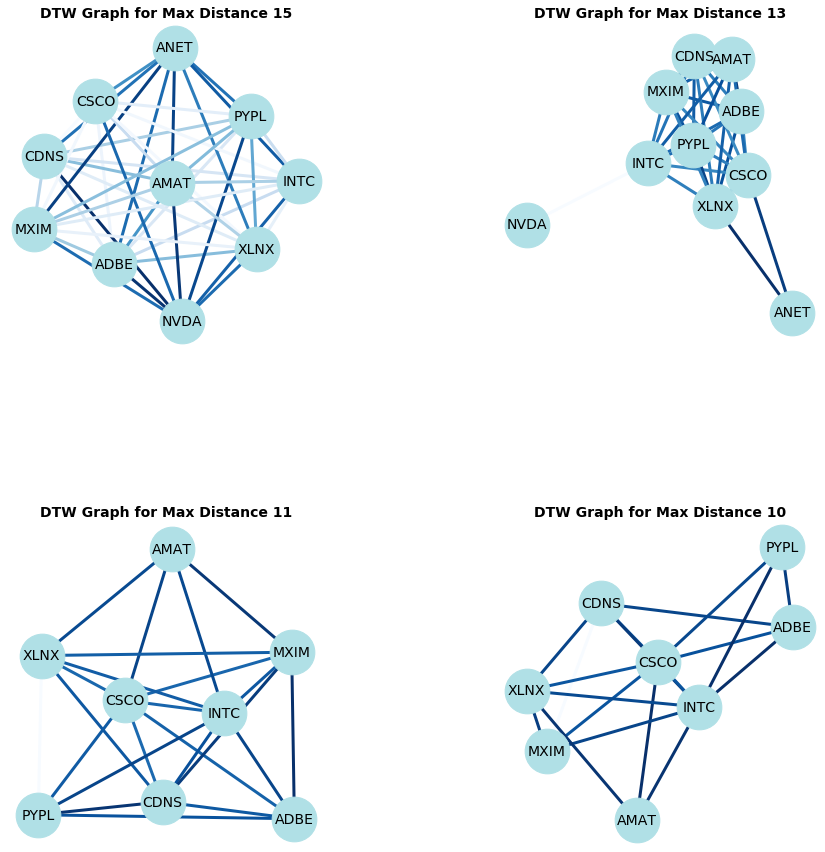

In [158]:
# Transform it in a links data frame (3 columns only):
links = dtw_matrix.stack().reset_index()
links.columns = ['var1', 'var2','value']

# List warping filers.
warps = [15, 13, 11, 10]

# Initialise figure.
fig, axes = subplot_init(2, 2, fig_size = (12, 12))
idx = 0

# For each warping threshold.
for w in warps:
    
    # Define axes.
    ax = axes[int(idx > 1)][int(idx % 2)]
    
    # Filter links.
    good_links = links.loc[abs(links['value'] < w) & (links['var1'] != links['var2'])]
    
    # Plot the network reversing distance metric.
    graph_plotter(good_links, ax = ax, std = max(dtw_matrix.max()), fact = 10000)
    nice_formatter(ax, title = 'DTW Graph for Max Distance ' + str(w), legend_on = False)
    idx += 1

# Save figure.
savefig(fig, section + 'dtw_shuffled_net' + file_fmt)    

## 5.5 Disadvantages of considering raw prices

This final section aims to discuss the usage of raw prices instead of the logarithmic returns in the analysis carried in the previous sections.
The main issue with using raw prices is that, as opposed to returns, prices are not independent from one another.
Given a time-series of raw prices $\boldsymbol{p}$ of length $t$ where $\boldsymbol{p}_i$ denotes the price of the asset at time $i$ the asset returns are defined as follows:
\begin{equation} \label{eq:def_r}
    \boldsymbol{r} = \frac{p_i - p_{i-1}}{p_{i-1}} \;\;\; for \;\; i = 1, ..., t
\end{equation}

Using the definition of returns given in equation above, the price at each time-step can be rewritten in terms of the returns, giving the following equation for the final price of the asset at time $t$ ($p_t$):
\begin{equation} \label{eq:p_t}
    p_t = p_0 + p_0r_1 + p_1r_2 + \dots + p_{t-1}r_t
\end{equation}

The equation above can be used recursively to rewrite all prices at each time-step in terms of a linear combination of previous prices times returns. Therefore, each price can be substituted by a linear combination of only the initial price and the returns. In this substitution earlier returns will retain higher importance, as they appear more often in the equation, whereas $r_t$ will only be included once, and $r_1$ will contribute $t$ times.
Physically this means that early price movements will have a higher significance in the computation of the correlation, compared to more recent price changes.